In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

from typing import Literal, Optional, Union
from scipy.stats import normaltest, skew, kurtosis
from scipy import stats

from sklearn.metrics import (
    mean_squared_error as sk_mse,
    mean_absolute_error as sk_mae,
    mean_absolute_percentage_error as sk_mape,
    r2_score as sk_r2
)
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split

## **Подготовка дата фреймов**

## *Очистка от пустых значений и дубликатов*

Загрузим обучающий и тестовый набор данных из CSV-файлов и посмотрим на них

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.head()

ApplicationDate   Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration  \
0      2010-06-26  27.0       66829.0        549.0     17290.0          60.0   
1      1996-09-23  55.0      172147.0        850.0     16110.0          36.0   
2      2015-01-19  51.0      300000.0        850.0     38436.0          36.0   
3      1981-05-12  25.0       34683.0        847.0     19186.0          48.0   
4      1995-05-07  55.0      300000.0        850.0     30437.0          48.0   

  MaritalStatus  NumberOfDependents HomeOwnershipStatus  MonthlyDebtPayments  \
0      Divorced                 1.0                Rent               1095.0   
1       Widowed                 1.0            Mortgage                211.0   
2       Married                 0.0            Mortgage                546.0   
3       Married                 0.0               Other                153.0   
4        Single                 2.0                Rent                562.0   

   ...  EmploymentStatus  EducationLevel  Experience  NetWorth  \
0  ...          Employed       Associate         4.0   35067.0   
1  ...          Employed     High School        33.0   27001.0   
2  ...          Employed        Bachelor        28.0  278382.0   
3  ...          Employed     High School         0.0    9224.0   
4  ...          Employed        Bachelor        31.0    4502.0   

   BaseInterestRate InterestRate  MonthlyLoanPayment  TotalDebtToIncomeRatio  \
0          0.257790     0.251465          508.970230                0.288013   
1          0.086110     0.093173          514.675859                0.050585   
2          0.108436     0.115443         1268.276385                0.072571   
3          0.100686     0.112822          498.505187                0.225415   
4          0.110437     0.089037          756.035156                0.052721   

   LoanApproved  RiskScore  
0           0.0  66.176500  
1           1.0  28.495737  
2           1.0  34.488104  
3           1.0  36.910753  
4           1.0  31.347091  

[5 rows x 36 columns]

In [4]:
test_df.head()

ID ApplicationDate  Age  AnnualIncome  CreditScore  LoanAmount  \
0   0      1979-01-03   49        207095          850       14458   
1   1      2006-04-10   28         64653          674       65491   
2   2      2013-11-28   41        300000          768       16811   
3   3      1995-08-24   50        300000          850       48737   
4   4      1980-06-15   35        300000          672       51916   

   LoanDuration MaritalStatus  NumberOfDependents HomeOwnershipStatus  ...  \
0            60        Single                   0                Rent  ...   
1            48        Single                   2                 Own  ...   
2            60        Single                   1                 Own  ...   
3            36      Divorced                   0            Mortgage  ...   
4            60        Single                   6            Mortgage  ...   

   JobTenure  EmploymentStatus  EducationLevel  Experience  NetWorth  \
0          6          Employed     High School          23     10626   
1          3          Employed     High School           3    299024   
2          3          Employed     High School          19      6979   
3          3     Self-Employed        Bachelor          26      8438   
4          7          Employed       Associate          12    436216   

   BaseInterestRate InterestRate  MonthlyLoanPayment  TotalDebtToIncomeRatio  \
0          0.104458     0.125350          325.532336                0.040650   
1          0.233491     0.260561         2210.247757                0.454410   
2          0.147811     0.154571          403.977431                0.034919   
3          0.118737     0.099712         1571.946906                0.085558   
4          0.230916     0.237727         1486.675235                0.063707   

   LoanApproved  
0             1  
1             0  
2             1  
3             1  
4             1  

[5 rows x 36 columns]

In [5]:
RiskScore = "RiskScore" # переменная для RiskScore, ибо спустя 4 часа уже лень каждый раз это писать
# upd: устал писать без подсказок
ApplicationDate = "ApplicationDate"
Age = "Age"
AnnualIncome = "AnnualIncome"
CreditScore = "CreditScore"
LoanAmount = "LoanAmount"
LoanDuration = "LoanDuration"
MonthlyDebtPayments = "MonthlyDebtPayments"
CreditCardUtilizationRate = "CreditCardUtilizationRate"
DebtToIncomeRatio = "DebtToIncomeRatio"
TotalDebtToIncomeRatio = "TotalDebtToIncomeRatio"
MaritalStatus = "MaritalStatus"
NumberOfDependents = "NumberOfDependents"
HomeOwnershipStatus = "HomeOwnershipStatus"
EducationLevel = "EducationLevel"
EmploymentStatus = "EmploymentStatus"
BankruptcyHistory = "BankruptcyHistory"
PreviousLoanDefaults = "PreviousLoanDefaults"
PaymentHistory = "PaymentHistory"
LengthOfCreditHistory = "LengthOfCreditHistory"
NumberOfCreditInquiries = "NumberOfCreditInquiries"
NumberOfOpenCreditLines = "NumberOfOpenCreditLines"
SavingsAccountBalance = "SavingsAccountBalance"
CheckingAccountBalance = "CheckingAccountBalance"
TotalAssets = "TotalAssets"
TotalLiabilities = "TotalLiabilities"
MonthlyIncome = "MonthlyIncome"
NetWorth = "NetWorth"
UtilityBillsPaymentHistory = "UtilityBillsPaymentHistory"
BaseInterestRate = "BaseInterestRate"
InterestRate = "InterestRate"
MonthlyLoanPayment = "MonthlyLoanPayment"
LoanApproved = "LoanApproved"
JobTenure = "JobTenure"
Experience = "Experience"
LoanPurpose = "LoanPurpose"

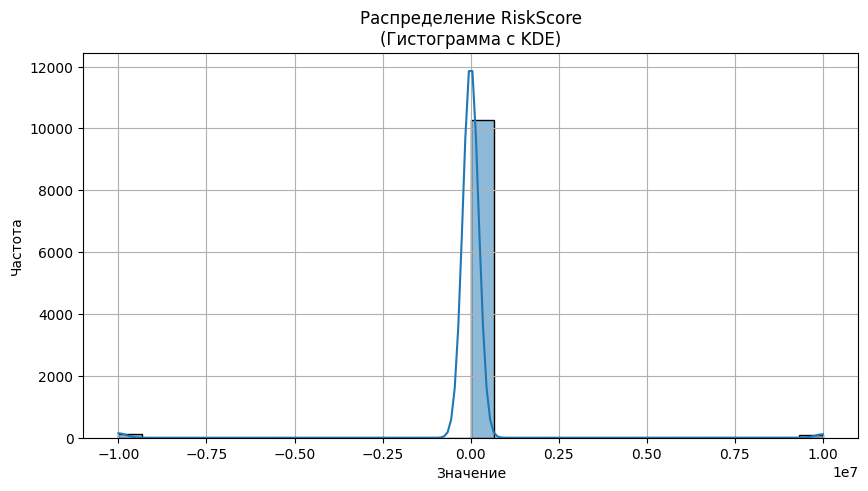

In [6]:
def plot_histogram_with_kde(data, column_name):
    plt.figure(figsize=(10, 5))
    # n_bins = int(1 + np.log2(len(train_df)))
    sns.histplot(data=data, x=column_name, bins=30, kde=True)
    plt.title(f'Распределение {column_name}\n(Гистограмма с KDE)')
    plt.xlabel('Значение')
    plt.ylabel('Частота')
    plt.grid(True)
    plt.show()
plot_histogram_with_kde(train_df, RiskScore)

Коробка с усами 🥸

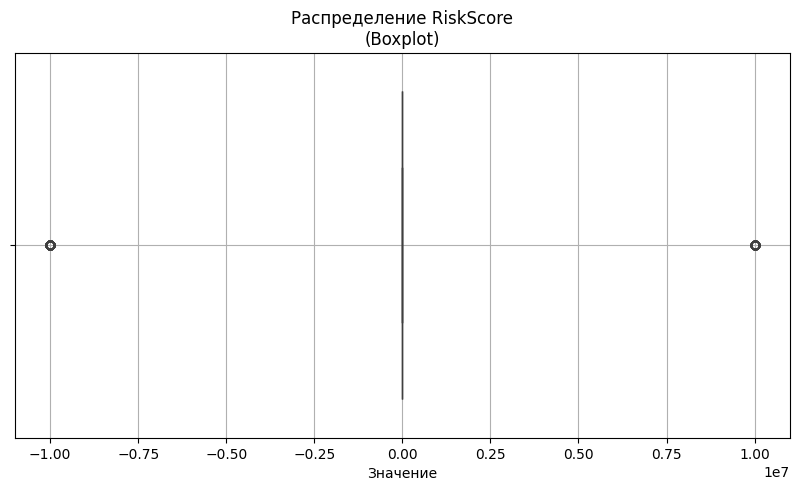

In [7]:
def plot_boxplot(data, column_name):
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=data, x=column_name)
    plt.title(f'Распределение {column_name}\n(Boxplot)')
    plt.xlabel('Значение')
    plt.grid(True)
    plt.show()
plot_boxplot(train_df, RiskScore)

Посмотрим на общий вид выборки данных (есть сильно выбивающиеся значения)

In [8]:
print(train_df[RiskScore].describe())

count    1.048700e+04
mean    -2.569878e+04
std      1.431675e+06
min     -9.999999e+06
25%      3.256475e+01
50%      4.411876e+01
75%      6.535690e+01
max      1.000000e+07
Name: RiskScore, dtype: float64


In [9]:
train_df[train_df[RiskScore] > 98][RiskScore].sort_values().head() #нет адекватных значений после RiskScore > 98

237     10000000.0
398     10000000.0
657     10000000.0
1168    10000000.0
1253    10000000.0
Name: RiskScore, dtype: float64

In [10]:
train_df[train_df[RiskScore] < 0][RiskScore].sort_values(ascending=False).head()

33    -9999999.0
56    -9999999.0
83    -9999999.0
183   -9999999.0
198   -9999999.0
Name: RiskScore, dtype: float64

In [11]:
def col_none_info(data, column_name):
  print(f"Кол-во None значений в {column_name}: {data[column_name].isnull().sum()}")
col_none_info(train_df, RiskScore)

Кол-во None значений в RiskScore: 530


In [12]:
train_df = train_df[(train_df['RiskScore'] >= 0) & (train_df['RiskScore'] <= 98)].copy()

In [13]:
col_none_info(train_df, RiskScore)

Кол-во None значений в RiskScore: 0


Получилось избавиться от выбивающихся значений + от пустых строк

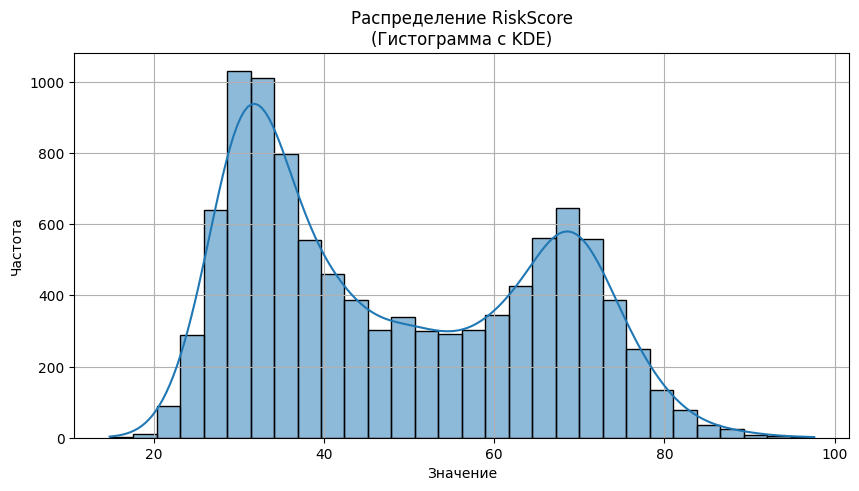

In [14]:
plot_histogram_with_kde(train_df, RiskScore)

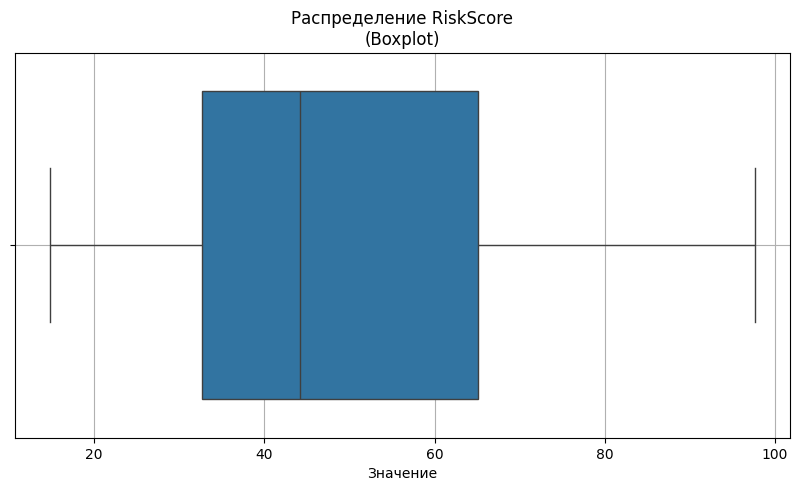

In [15]:
plot_boxplot(train_df, RiskScore)

Поработаем с пустыми записями в других столбцах

In [16]:
def none_info(data):
  missed_per_column = data.isnull().sum()
  missed_per_column = missed_per_column[missed_per_column > 0]
  print("Информация о пустых записях:", len(missed_per_column))
  print(missed_per_column)
none_info(train_df)

Информация о пустых записях: 9
CreditScore               485
LoanAmount                485
MonthlyDebtPayments       485
BankruptcyHistory         485
LoanPurpose               485
CheckingAccountBalance    485
TotalAssets               485
NetWorth                  485
BaseInterestRate          485
dtype: int64


In [17]:
numeric_cols = train_df.select_dtypes(include=np.number).columns
categorical_cols = train_df.select_dtypes(exclude=np.number).columns

print("Числовые признаки:", len(numeric_cols))
print(numeric_cols)
print("\nКатегориальные признаки:", len(categorical_cols))
print(categorical_cols)

train_df[numeric_cols] = train_df[numeric_cols].fillna(train_df[numeric_cols].mean())
train_df[categorical_cols] = train_df[categorical_cols].fillna(
    train_df[categorical_cols].mode().iloc[0]
)
none_info(train_df)

Числовые признаки: 30
Index(['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration',
       'NumberOfDependents', 'MonthlyDebtPayments',
       'CreditCardUtilizationRate', 'NumberOfOpenCreditLines',
       'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory',
       'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory',
       'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets',
       'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory',
       'JobTenure', 'Experience', 'NetWorth', 'BaseInterestRate',
       'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio',
       'LoanApproved', 'RiskScore'],
      dtype='object')

Категориальные признаки: 6
Index(['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus',
       'LoanPurpose', 'EmploymentStatus', 'EducationLevel'],
      dtype='object')
Информация о пустых записях: 0
Series([], dtype: int64)


Избавимся от дубликатов

In [18]:
num_duplicates = train_df.duplicated().sum()
print("Количество полных дубликатов:", num_duplicates)

Количество полных дубликатов: 484


In [19]:
train_df = train_df.drop_duplicates()

In [20]:
num_duplicates = train_df.duplicated().sum()
print("Количество полных дубликатов:", num_duplicates)

Количество полных дубликатов: 0


## *Графики зависимости*

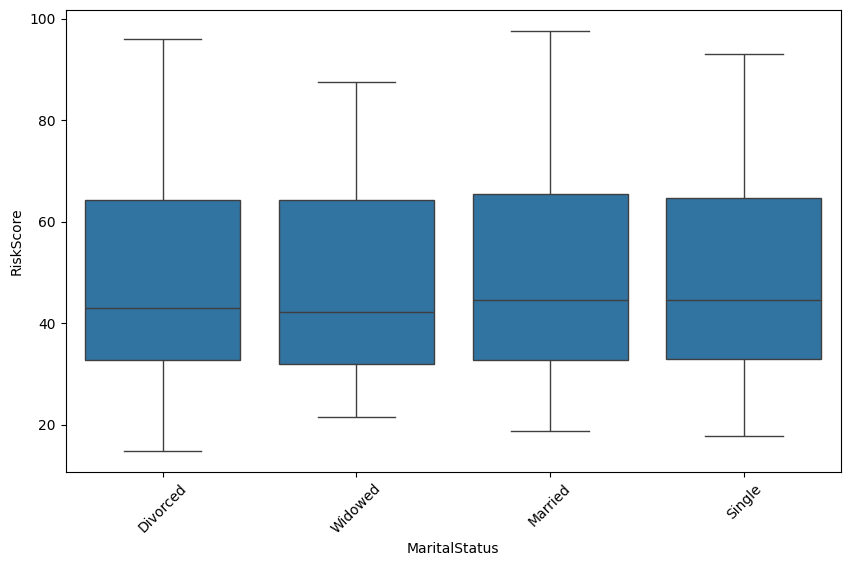

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=MaritalStatus, y=RiskScore, data=train_df)
plt.xticks(rotation=45)
plt.show()

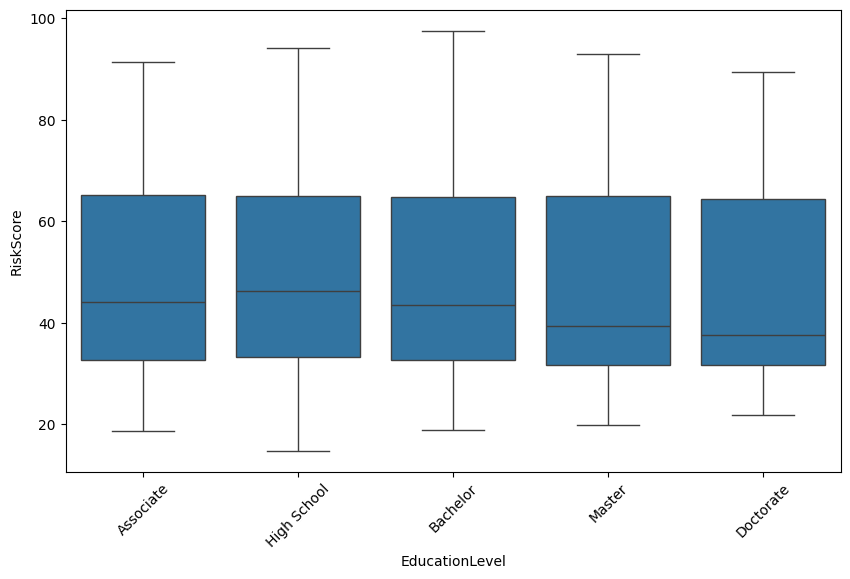

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=EducationLevel, y=RiskScore, data=train_df)
plt.xticks(rotation=45)
plt.show()

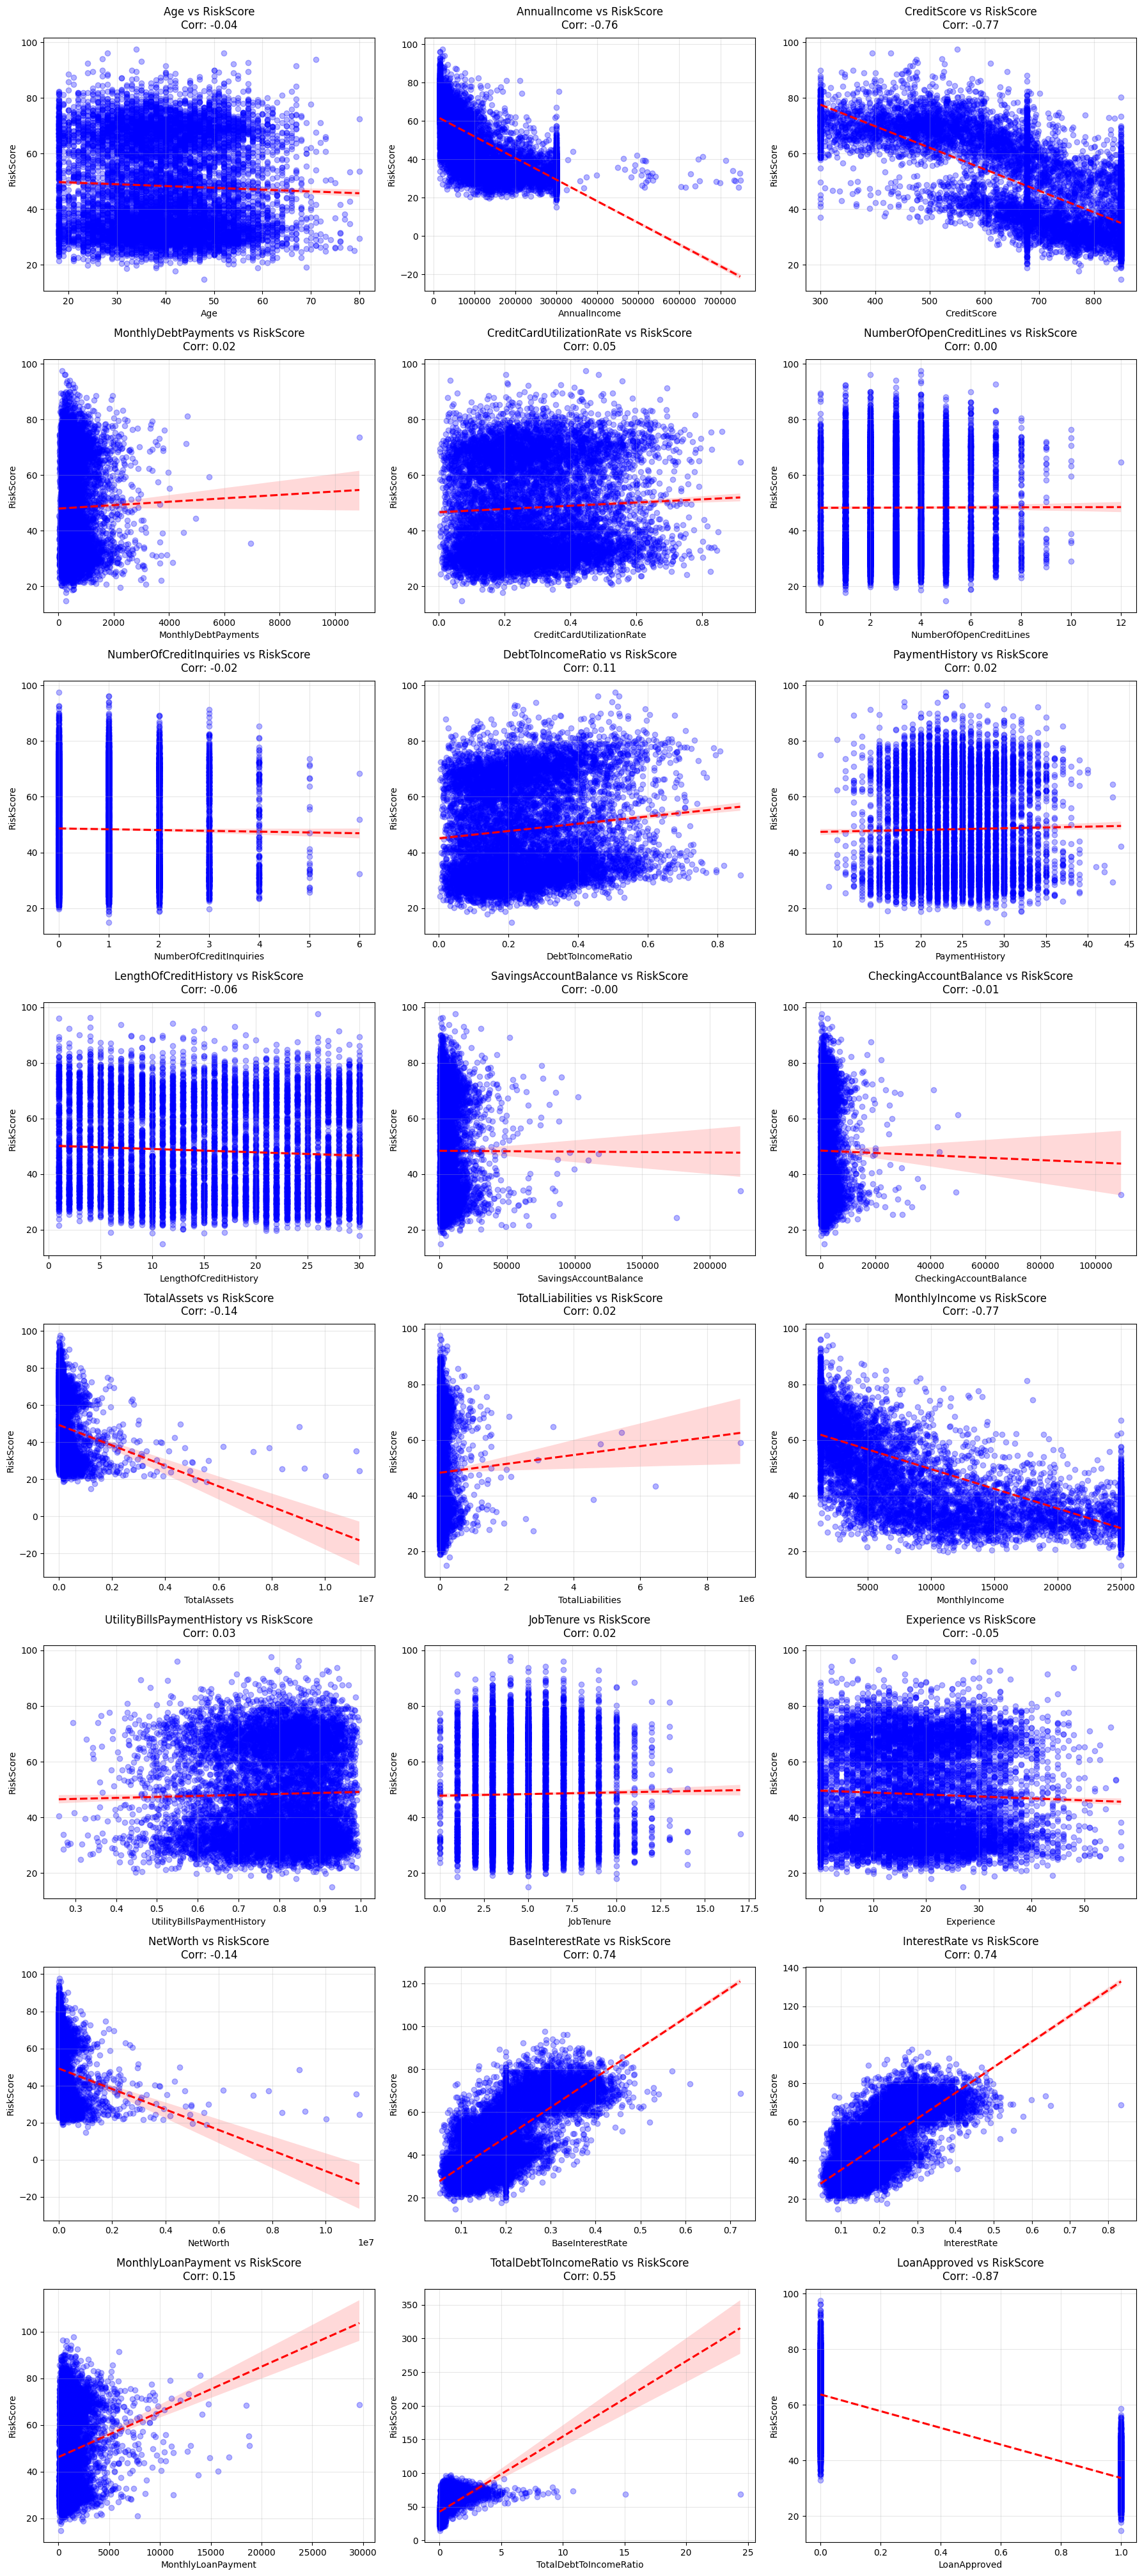

In [23]:
def plot_all_features_vs_risk(df, exclude_columns=[EducationLevel, MaritalStatus, LoanAmount, ApplicationDate, LoanDuration, NumberOfDependents, BankruptcyHistory, PreviousLoanDefaults]):

    numeric_cols = df.select_dtypes(include=np.number).columns
    target = RiskScore
    features_to_plot = [col for col in numeric_cols
                       if col not in exclude_columns + [target]]

    n_cols = 3
    n_rows = len(features_to_plot) // n_cols + 1
    plt.figure(figsize=(18, 5*n_rows))

    for i, feature in enumerate(features_to_plot, 1):
        plt.subplot(n_rows, n_cols, i)

        sns.regplot(
            data=df,
            x=feature,
            y=target,
            scatter_kws={'alpha': 0.3, 'color': 'blue'},
            line_kws={'color': 'red', 'linestyle': '--'}
        )

        corr = df[[feature, target]].corr().iloc[0,1]
        plt.title(f'{feature} vs {target}\nCorr: {corr:.2f}', pad=10)
        plt.xlabel(feature)
        plt.ylabel(target)
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_all_features_vs_risk(train_df)

Второй график: ♟️♟️♟️

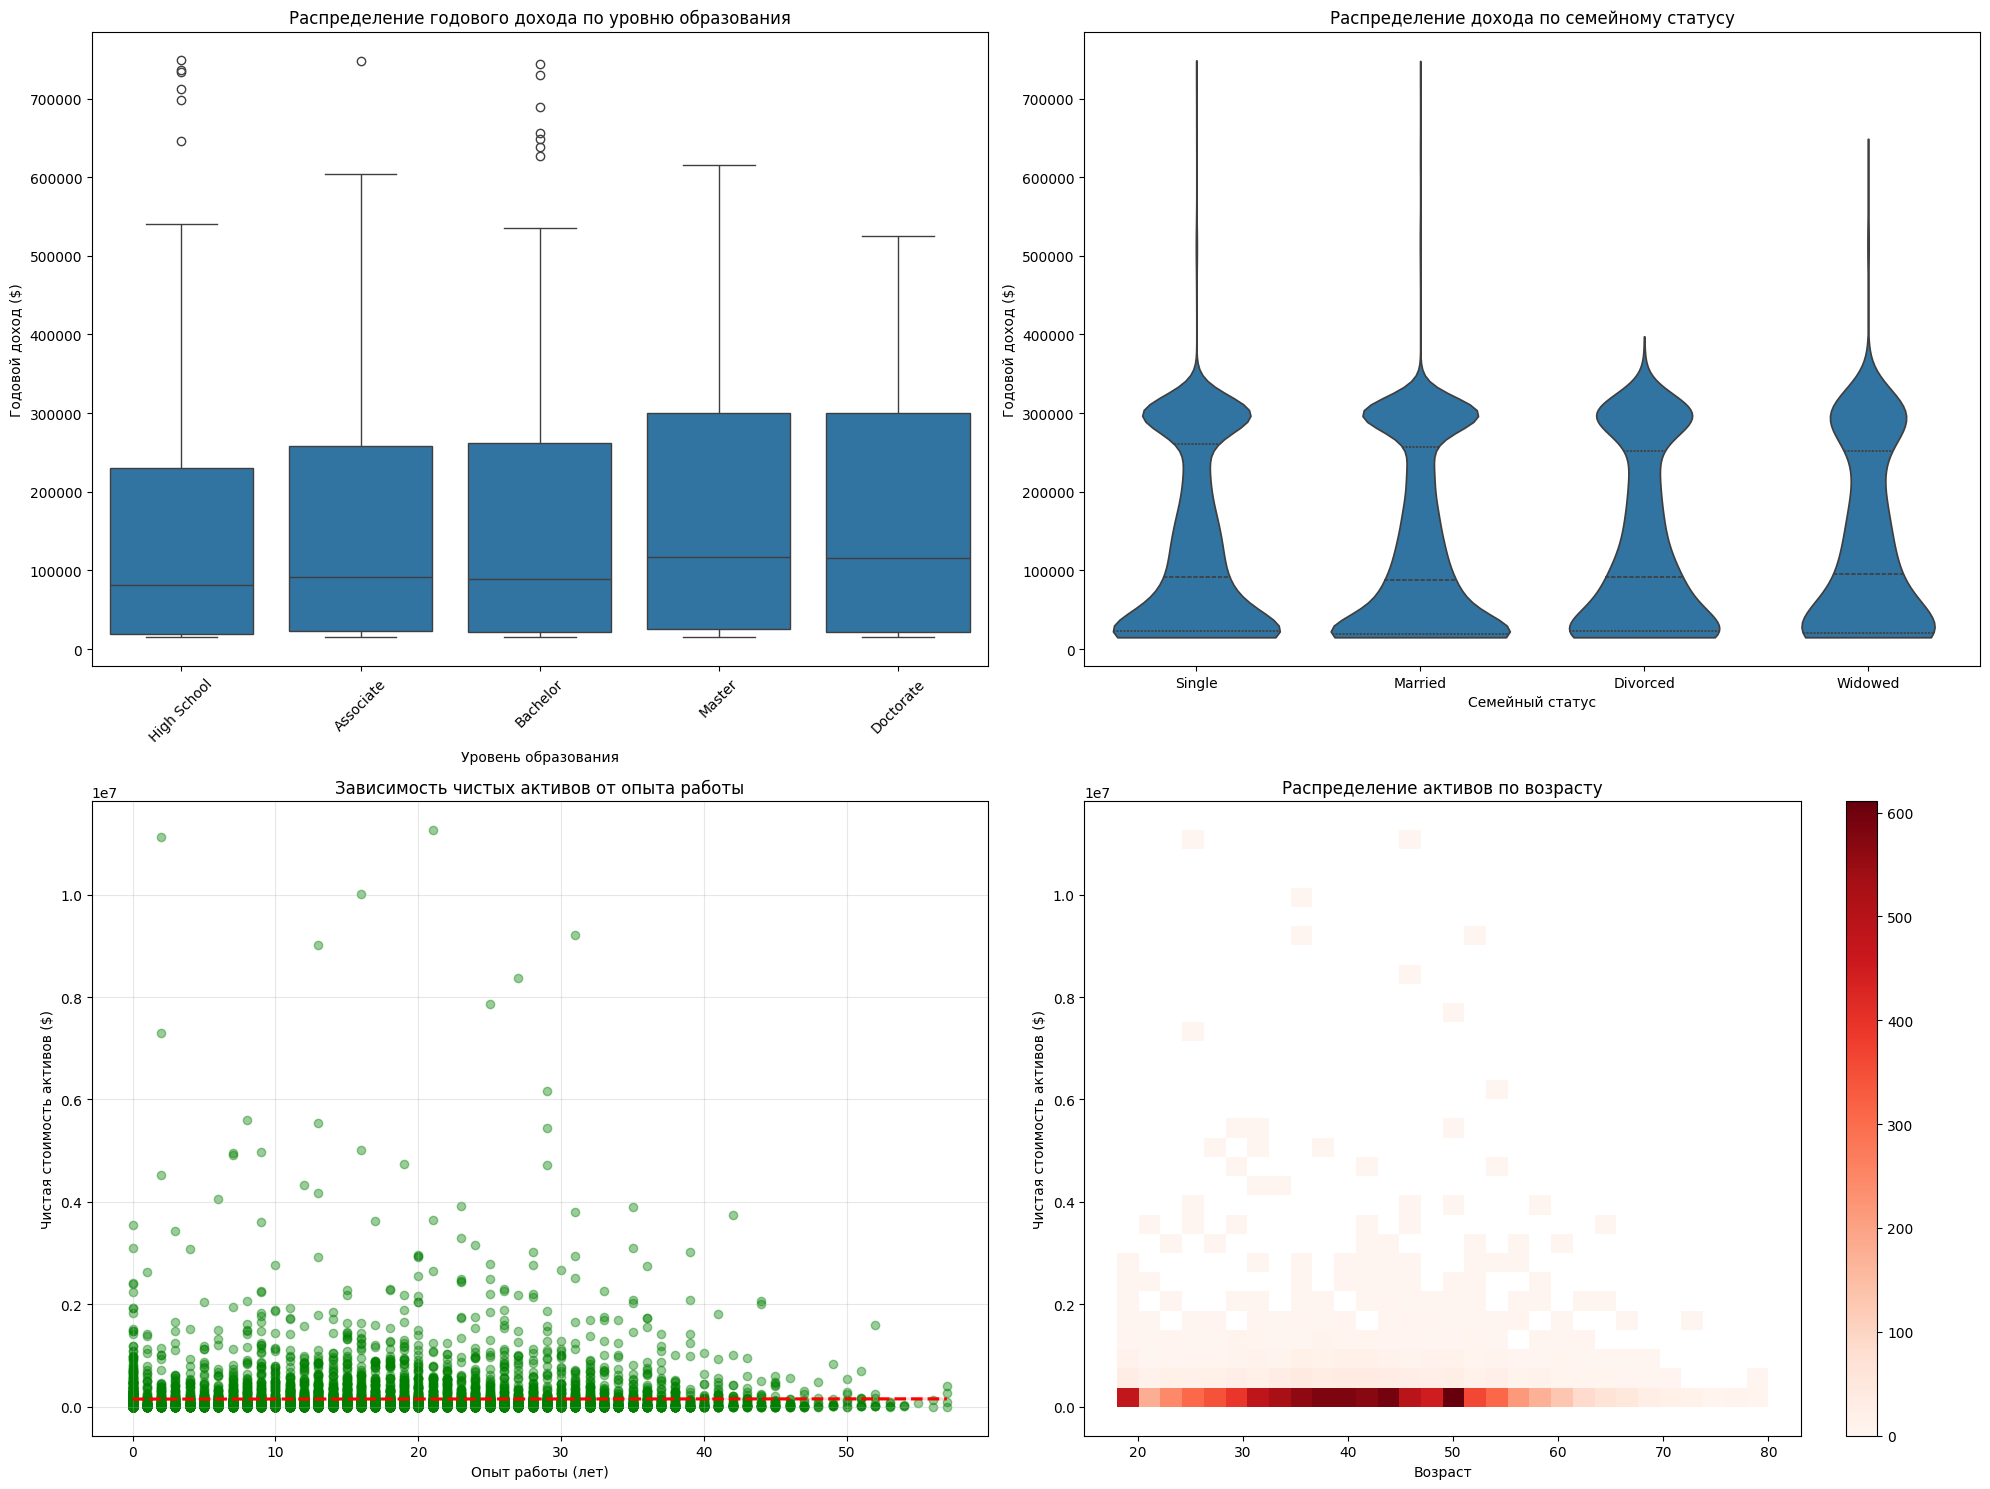

In [24]:
def plot_custom_relationships(df):

    plt.figure(figsize=(20, 15))

    plt.subplot(2, 2, 1)
    education_order = ['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate']
    sns.boxplot(data=df, x='EducationLevel', y='AnnualIncome', order=education_order)
    plt.title('Распределение годового дохода по уровню образования', fontsize=12)
    plt.xlabel('Уровень образования')
    plt.ylabel('Годовой доход ($)')
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 2)
    marital_order = ['Single', 'Married', 'Divorced', 'Widowed']
    sns.violinplot(data=df, x='MaritalStatus', y='AnnualIncome', order=marital_order,
                   cut=0, inner="quartile")
    plt.title('Распределение дохода по семейному статусу', fontsize=12)
    plt.xlabel('Семейный статус')
    plt.ylabel('Годовой доход ($)')

    plt.subplot(2, 2, 3)
    sns.regplot(data=df, x='Experience', y='NetWorth',
                scatter_kws={'alpha':0.4, 'color':'green'},
                line_kws={'color':'red', 'linestyle':'--'})
    plt.title('Зависимость чистых активов от опыта работы', fontsize=12)
    plt.xlabel('Опыт работы (лет)')
    plt.ylabel('Чистая стоимость активов ($)')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 2, 4)
    sns.histplot(data=df, x='Age', y='NetWorth',
                bins=30, cmap='Reds', cbar=True)
    plt.title('Распределение активов по возрасту', fontsize=12)
    plt.xlabel('Возраст')
    plt.ylabel('Чистая стоимость активов ($)')

    plt.tight_layout()
    plt.show()

plot_custom_relationships(train_df)

## *Преобразование категориальных признаков*

ApplicationDate приведем к типу date и разобъем на год, месяц и день.

In [25]:
def change_application_date(df):
  df2 = df.copy()
  df2[ApplicationDate]  = pd.to_datetime(df2[ApplicationDate], format='%Y-%m-%d')
  df2['ApplicationYear']  = df2[ApplicationDate].dt.year
  df2['ApplicationMonth'] = df2[ApplicationDate].dt.month
  df2['ApplicationDay']   = df2[ApplicationDate].dt.day
  df2.drop(columns=[ApplicationDate], inplace=True)
  return df2

train_df = change_application_date(train_df)
test_df  = change_application_date(test_df)

In [26]:
for column in categorical_cols.drop('ApplicationDate'):
    unique_values = train_df[column].unique()
    print(f"{column}: {unique_values}")

MaritalStatus: ['Divorced' 'Widowed' 'Married' 'Single']
HomeOwnershipStatus: ['Rent' 'Mortgage' 'Other' 'Own']
LoanPurpose: ['Education' 'Home' 'Debt Consolidation' 'Auto' 'Other']
EmploymentStatus: ['Employed' 'Self-Employed' 'Unemployed']
EducationLevel: ['Associate' 'High School' 'Bachelor' 'Master' 'Doctorate']


Время для One-hot encoding

In [27]:
CATEGORICAL_FEATURES = [
    MaritalStatus,
    HomeOwnershipStatus,
    LoanPurpose,
    EducationLevel,
    EmploymentStatus
]

def one_hot_encode(df, features):
    return pd.get_dummies(
        df,
        columns=features,
        prefix=features
    )

train_df = one_hot_encode(train_df, CATEGORICAL_FEATURES)
test_df = one_hot_encode(test_df, CATEGORICAL_FEATURES)

In [28]:
train_df.head()

Age  AnnualIncome  CreditScore  LoanAmount  LoanDuration  \
0  27.0       66829.0        549.0     17290.0          60.0   
1  55.0      172147.0        850.0     16110.0          36.0   
2  51.0      300000.0        850.0     38436.0          36.0   
3  25.0       34683.0        847.0     19186.0          48.0   
4  55.0      300000.0        850.0     30437.0          48.0   

   NumberOfDependents  MonthlyDebtPayments  CreditCardUtilizationRate  \
0                 1.0               1095.0                   0.151985   
1                 1.0                211.0                   0.175693   
2                 0.0                546.0                   0.444605   
3                 0.0                153.0                   0.188452   
4                 2.0                562.0                   0.273431   

   NumberOfOpenCreditLines  NumberOfCreditInquiries  ...  LoanPurpose_Home  \
0                      2.0                      1.0  ...             False   
1                      3.0                      0.0  ...              True   
2                      3.0                      0.0  ...             False   
3                      7.0                      0.0  ...             False   
4                      3.0                      1.0  ...             False   

   LoanPurpose_Other  EducationLevel_Associate  EducationLevel_Bachelor  \
0              False                      True                    False   
1              False                     False                    False   
2              False                     False                     True   
3              False                     False                    False   
4              False                     False                     True   

   EducationLevel_Doctorate  EducationLevel_High School  \
0                     False                       False   
1                     False                        True   
2                     False                       False   
3                     False                        True   
4                     False                       False   

   EducationLevel_Master  EmploymentStatus_Employed  \
0                  False                       True   
1                  False                       True   
2                  False                       True   
3                  False                       True   
4                  False                       True   

   EmploymentStatus_Self-Employed  EmploymentStatus_Unemployed  
0                           False                        False  
1                           False                        False  
2                           False                        False  
3                           False                        False  
4                           False                        False  

[5 rows x 54 columns]

## *Снова работаем с данными*

Посмотрим на матрицу корреляции

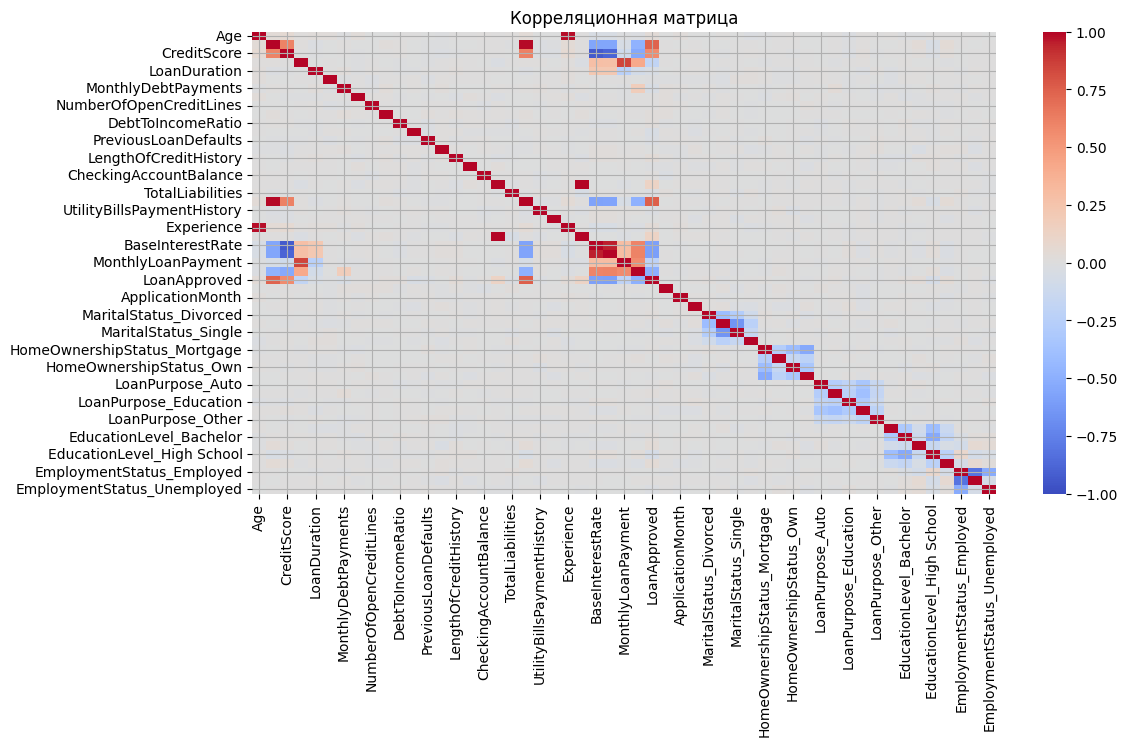

In [29]:
def show_corr_matrix(data, min_corr = 0, annot = False, dropTarget = True, fmt='.2g', figsize=(12, 6), grid=False, name = "Корреляционная матрица" ):
  if dropTarget:
    data = data.drop(columns=RiskScore, errors='ignore')
  corr_matrix = data.corr()
  plt.figure(figsize=figsize)
  sns.heatmap(corr_matrix[corr_matrix.abs() > min_corr], cmap='coolwarm', vmin=-1, vmax=1, annot=annot, fmt=fmt)
  plt.title(name)
  plt.grid(grid)
  plt.show()

show_corr_matrix(train_df, grid=True)

Рассмотрим "подозрительные" значения поближе и построим график только значимых корреляций

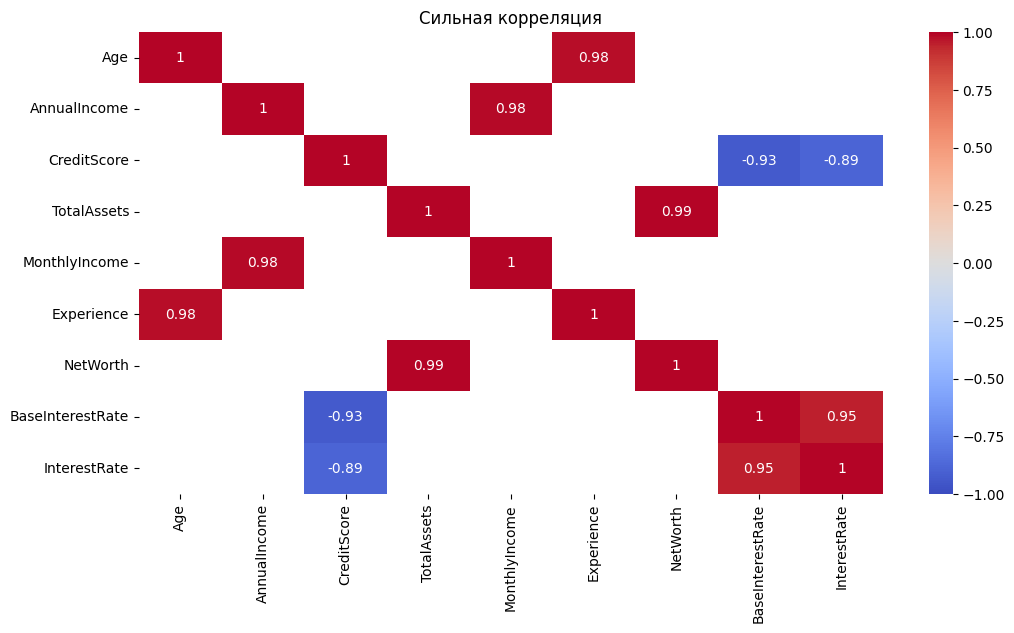

In [30]:
corr_matrix = train_df.drop(columns=[RiskScore]).corr()

weak_corr_columns = corr_matrix.columns[corr_matrix.abs().apply(lambda x: x[x < 1].max(), axis=0) < 0.85]

show_corr_matrix(
    train_df.drop(columns=weak_corr_columns),
    min_corr=0.85,
    annot=True,
    name='Сильная корреляция'
)

Опытным путем я обнаружил, что MSE будет выше в случае применения преобразований до работы с мультиколлинеарностью.
Так же при применении многократного логарифмирования к нашему дата-сету показатель MSE заметно выше, чем при примененнии преобразования Бокса-Кокса (ниже можно будет ознакомиться с жалкими попытками нормализации данных (спойлер: ни к чему хорошему это не привело))

In [31]:
dummy_train_df = train_df.copy() # для дальнейшего dummy-исследования
dummy_test_df = test_df.copy()

In [33]:
def log_transform(train_df=train_df, test_df=test_df, target=RiskScore, skew_thresh=0.5, n=3):
  for i in range(n):
    for col in train_df.drop(columns=RiskScore).select_dtypes(include=np.number).columns:
        if skew(train_df[col]) > skew_thresh:
          train_df[f"log_{col}"] = np.log1p(train_df[col])
          train_df.drop(columns=[col], inplace=True)
          test_df[f"log_{col}"] = np.log1p(test_df[col])
          test_df.drop(columns=[col], inplace=True)
log_transform()

Посморим, как изменились наши матрицы

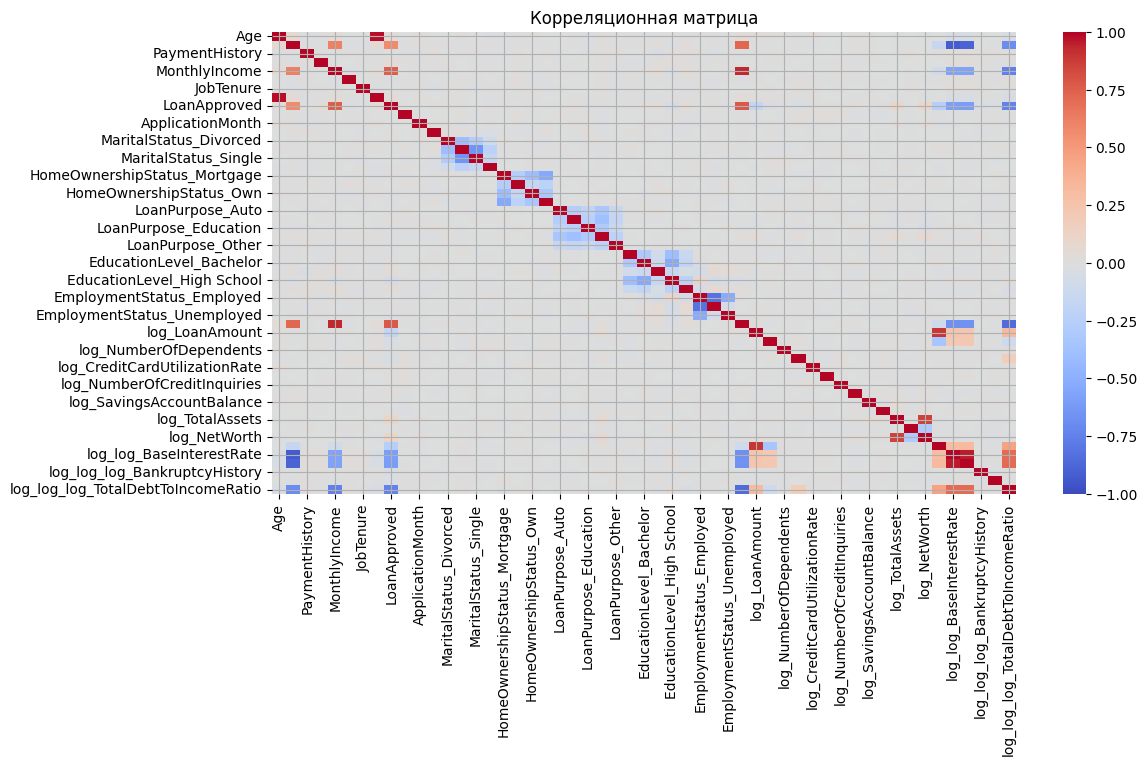

In [34]:
show_corr_matrix(train_df, grid=True) #был удивлен, когда это увидел

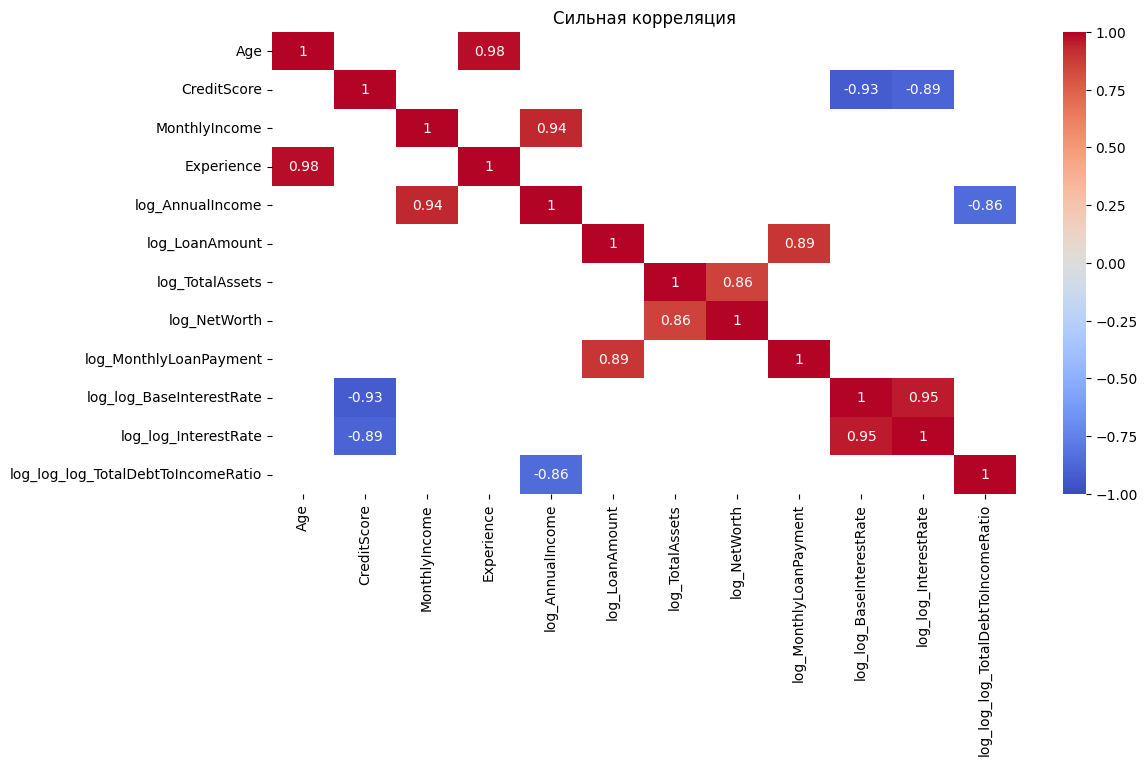

In [35]:
corr_matrix = train_df.drop(columns=[RiskScore]).corr()

weak_corr_columns = corr_matrix.columns[corr_matrix.abs().apply(lambda x: x[x < 1].max(), axis=0) < 0.85]

show_corr_matrix(
    train_df.drop(columns=weak_corr_columns),
    min_corr=0.85,
    annot=True,
    name='Сильная корреляция'
)

В принципе, можно убрать Age и оставить только Experience, но это не повлияет / негативно повлияет на MSE

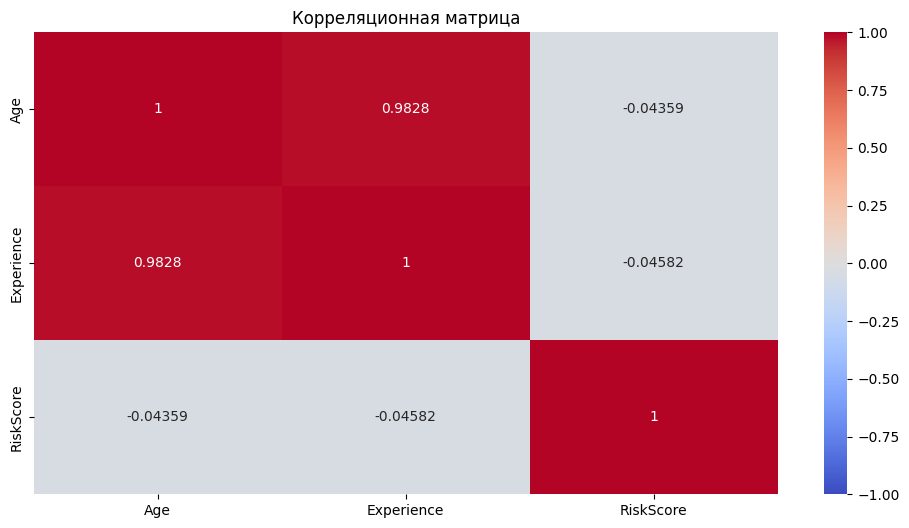

In [36]:
show_corr_matrix(train_df[[Age, Experience, RiskScore]], annot=True, dropTarget=False, fmt='.4g')

Видно, что возраст является менее влиятельным признаком для расчета риск скора, значит, можем его убрать

In [475]:
# train_df.drop(Age, axis=1, inplace=True)
# test_df.drop(Age, axis=1, inplace=True)

## *Как оказалось позже, практически бесполезное исследование (потраченого времени жаль, но мы старались...)*

Оставил для ознакомления

Изначально провоил данное исследование после работы с мультиколлинеарностью и удалением некоторых признаков

Построим графики для сравнения наших распределений с нормальным

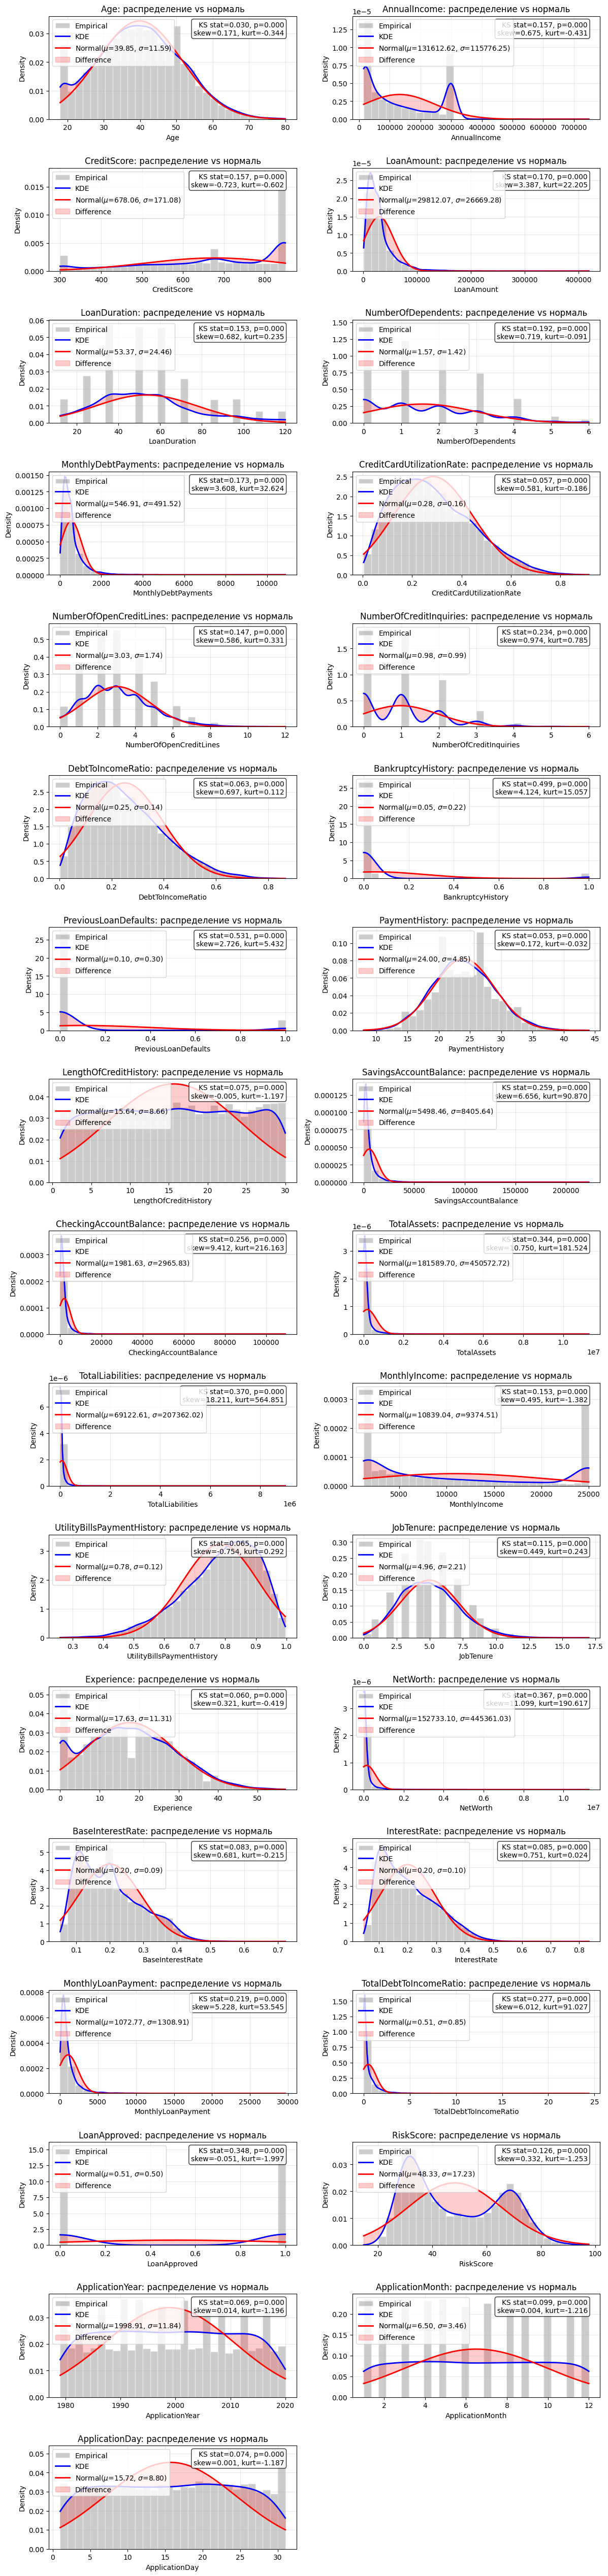

In [37]:
def compare_with_normal(df):
    numeric_cols = df.select_dtypes(include=np.number).columns
    num_cols = len(numeric_cols)

    fig, axes = plt.subplots(nrows=(num_cols + 1) // 2, ncols=2,
                            figsize=(12, 3 * ((num_cols + 1) // 2)))

    if num_cols == 1:
        axes = np.array([axes])

    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        ax = axes[i]
        x = df[col].dropna().values
        mu, sigma = x.mean(), x.std(ddof=0)

        is_integer = np.issubdtype(x.dtype, np.integer) or (np.unique(x).size < 20)

        count, bins, _ = ax.hist(x, bins=30, density=True,
                                alpha=0.4, color='gray',
                                edgecolor='white', label='Empirical')

        xs = np.linspace(bins[0], bins[-1], 200)

        if is_integer:
            kde = stats.gaussian_kde(x)
            kde.set_bandwidth(bw_method=kde.factor * 1.5)
        else:
            kde = stats.gaussian_kde(x)
        pdf_kde = kde(xs)
        ax.plot(xs, pdf_kde, color='blue', lw=2, label='KDE')

        pdf_norm = stats.norm.pdf(xs, loc=mu, scale=sigma)
        ax.plot(xs, pdf_norm, color='red', lw=2,
               label=f'Normal($\\mu$={mu:.2f}, $\\sigma$={sigma:.2f})')

        ax.fill_between(xs,
                       np.minimum(pdf_kde, pdf_norm),
                       np.maximum(pdf_kde, pdf_norm),
                       color='red', alpha=0.2,
                       label='Difference')

        ks_stat, ks_p = stats.kstest(x, 'norm', args=(mu, sigma))
        skewness = stats.skew(x)
        kurt = stats.kurtosis(x)
        text = (f"KS stat={ks_stat:.3f}, p={ks_p:.3f}\n"
               f"skew={skewness:.3f}, kurt={kurt:.3f}")
        ax.text(0.95, 0.95, text, transform=ax.transAxes,
               ha='right', va='top',
               bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

        ax.set_title(f"{col}: распределение vs нормаль")
        ax.set_xlabel(col)
        ax.set_ylabel("Density")
        ax.legend(loc='upper left')
        ax.grid(alpha=0.3)

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

compare_with_normal(dummy_train_df)

По графикам видно, что большинство признаков имеет практически нормальное распределение. Попробуем сделать его еще лучше

In [38]:
def selective_transform(df, log_cols=None, boxcox_cols=None, target_col='RiskScore'):
    if log_cols is None:
        log_cols = []
    if boxcox_cols is None:
        boxcox_cols = []

    transformed_df = df.copy()
    log_params = {}
    boxcox_params = {}

    for col in log_cols:
        if col in transformed_df.columns and col != target_col:
            x = transformed_df[col].values.astype(float)
            if np.any(x <= 0):
                shift = abs(x.min()) + 1e-6
                x = x + shift
            else:
                shift = 0
            transformed_df[col] = np.log1p(x)
            log_params[col] = shift

    for col in boxcox_cols:
        if col in transformed_df.columns and col != target_col:
            x = transformed_df[col].values.astype(float)
            if np.any(x <= 0):
                shift = abs(x.min()) + 1e-6
                x = x + shift
            else:
                shift = 0
            x_bc, lam = stats.boxcox(x)
            transformed_df[col] = x_bc
            boxcox_params[col] = (lam, shift)

    return transformed_df, log_params, boxcox_params

boxcox_columns = dummy_train_df.select_dtypes(include=np.number).columns

boxed, log_params, boxcox_params = selective_transform(
    dummy_train_df,
    boxcox_cols=boxcox_columns,
    target_col=RiskScore
)

log_columns = dummy_train_df.select_dtypes(include=np.number).columns

loged, log_params, boxcox_params = selective_transform(
    dummy_train_df,
    log_cols=log_columns,
    target_col=RiskScore
)

Посмотрим, как на выборке отразится логарифмирование

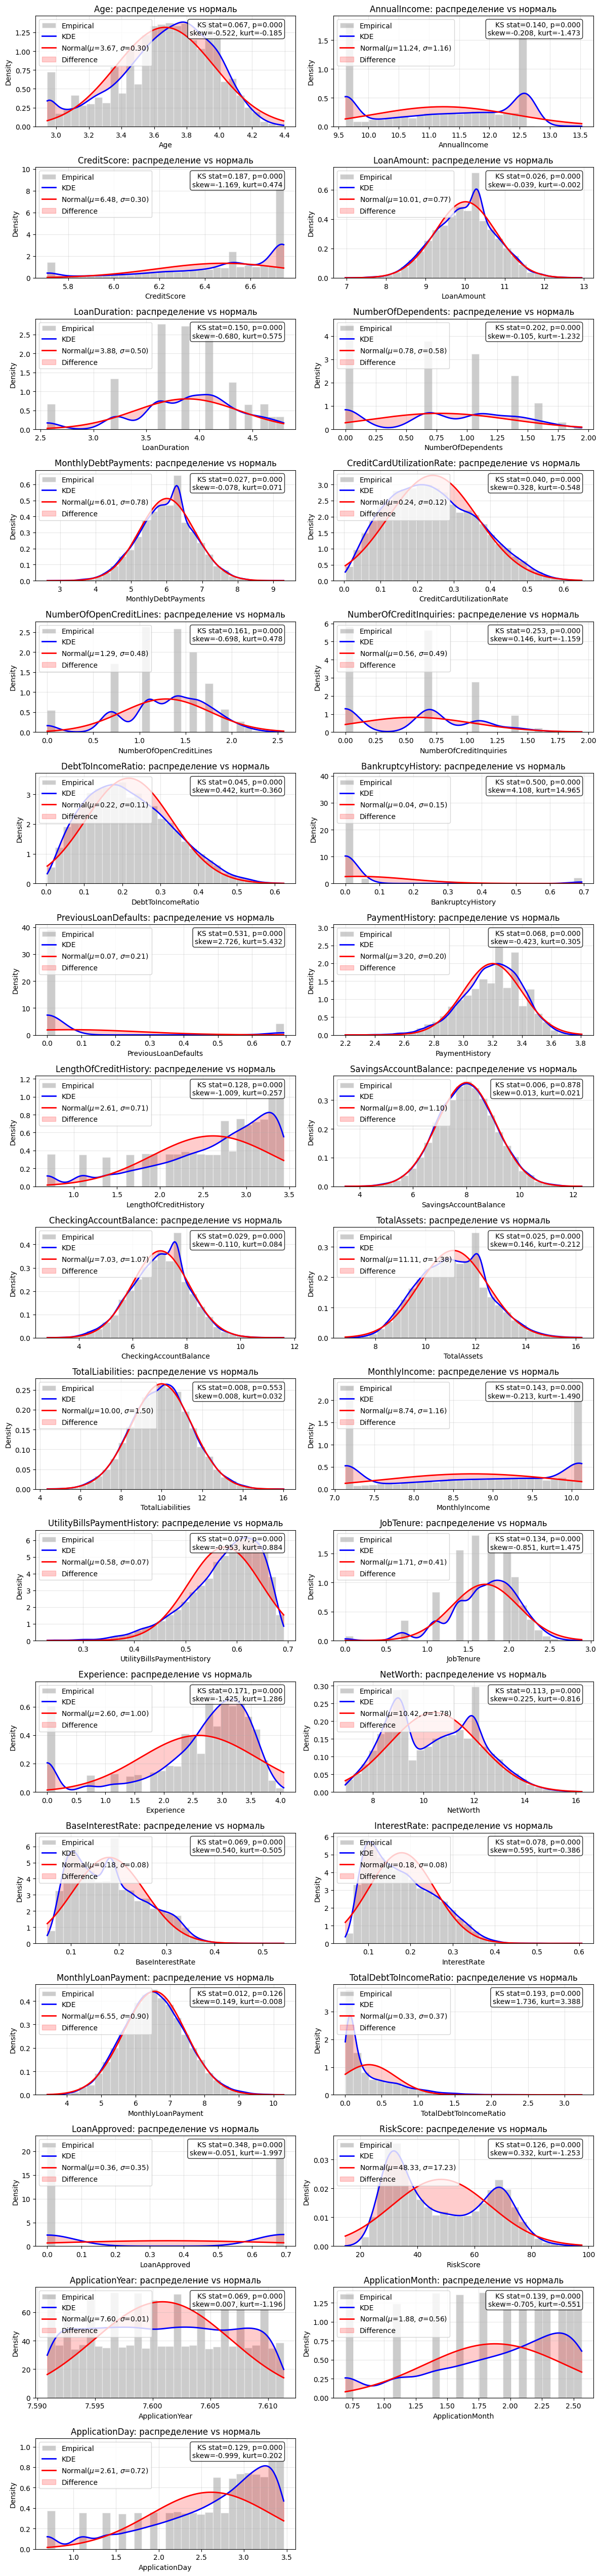

In [39]:
compare_with_normal(loged)

Преобразование Бокса-Кокса

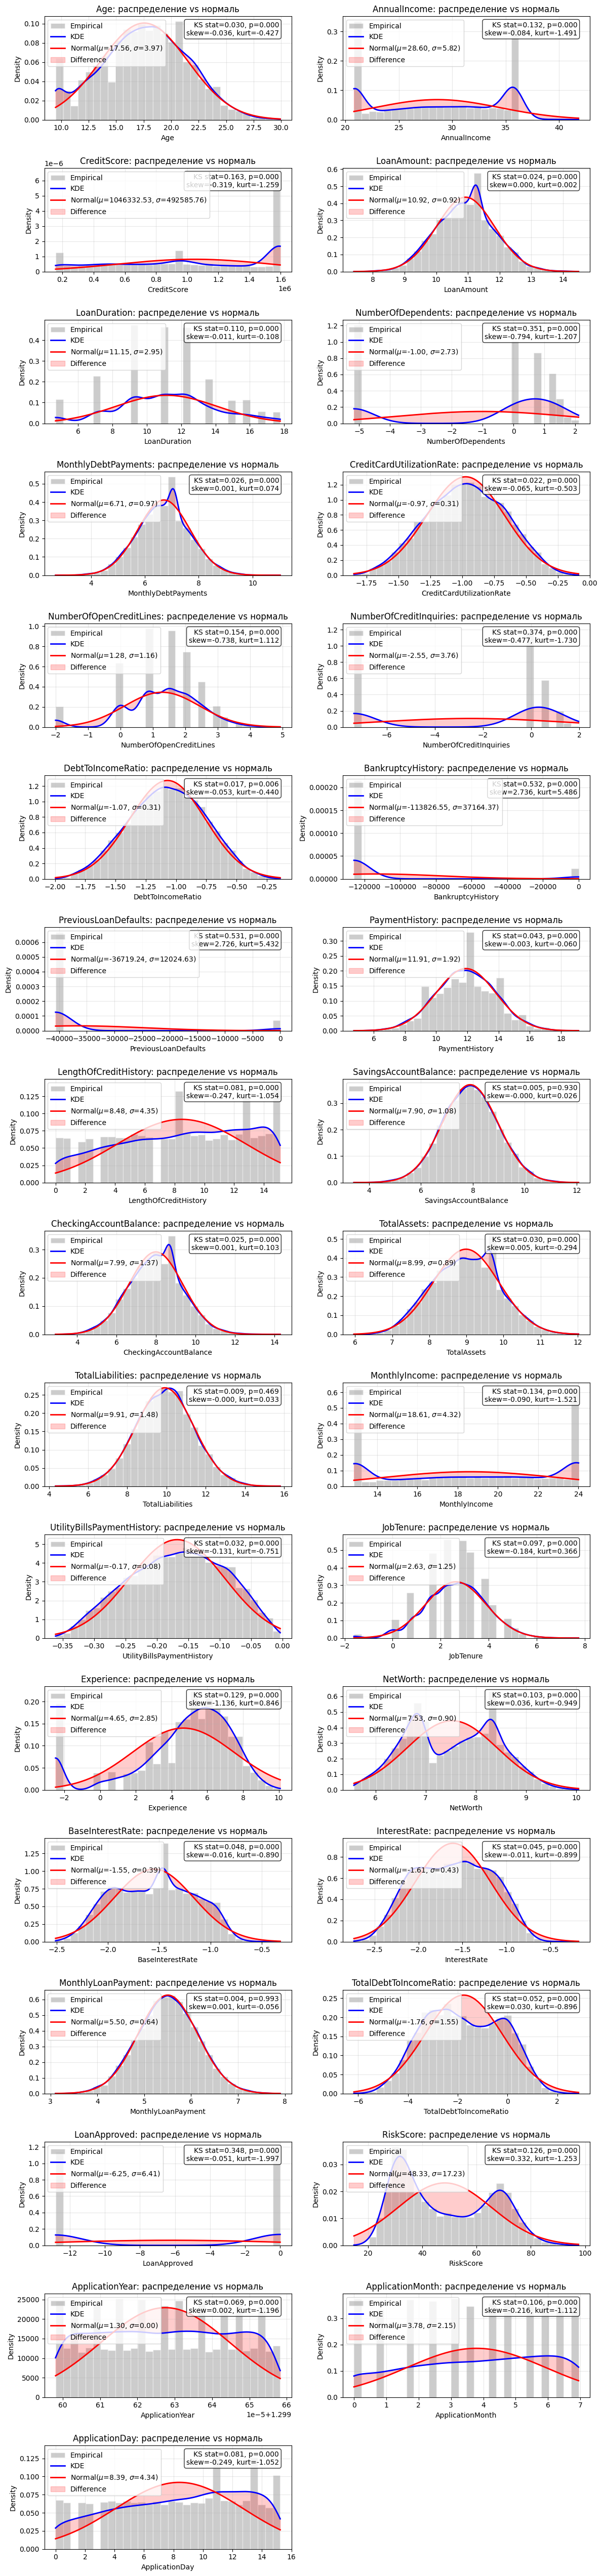

In [40]:
compare_with_normal(boxed)

Здесь мне очень хотелось посмотреть на таблицу и сравнить преобразования

In [41]:
from IPython.display import display

def compare_transforms_metrics(*dfs_with_names, target_col='RiskScore'):

    metrics_dict = {}

    for name, df in dfs_with_names:
        numeric_cols = df.select_dtypes(include=np.number).columns.drop(target_col, errors='ignore')
        metrics = {}

        for col in numeric_cols:
            x = df[col].dropna().values
            mu, sigma = x.mean(), x.std(ddof=0)
            ks_stat, _ = stats.kstest(x, 'norm', args=(mu, sigma))
            skewness = stats.skew(x)
            kurt = stats.kurtosis(x)
            metrics[col] = {
                'KS_stat': ks_stat,
                'abs_skew': abs(skewness),
                'abs_kurtosis': abs(kurt)
            }

        metrics_dict[name] = pd.DataFrame(metrics).T

    combined = pd.concat(metrics_dict, axis=1)

    subsets = {
        'KS_stat': [],
        'abs_skew': [],
        'abs_kurtosis': []
    }

    for name in metrics_dict.keys():
        for metric in subsets.keys():
            subsets[metric].append((name, metric))

    styled = (
        combined.style
        .highlight_min(
            axis=1,
            subset=subsets['KS_stat'],
            color='lightgreen'
        )
        .highlight_min(
            axis=1,
            subset=subsets['abs_skew'],
            color='lightblue'
        )
        .highlight_min(
            axis=1,
            subset=subsets['abs_kurtosis'],
            color='lightcoral'
        )
        .format("{:.4f}")
    )

    num_groups = len(metrics_dict)
    if num_groups > 1:
        border_styles = [
            {'selector': 'th.col_heading.level0', 'props': 'border-left: 1px solid black'},
            {'selector': 'th.col_heading.level0:first-child', 'props': 'border-left: none'},
        ]

        if num_groups > 2:
            for n in range(1, num_groups):
                border_styles.append({
                    'selector': f'th.col_heading.level0:nth-child({num_groups*n+1})',
                    'props': 'border-left: 2px solid black !important;'
                })

        styled = styled.set_table_styles(border_styles)

    styled = styled.set_table_styles([
        {'selector': 'tr', 'props': 'border-bottom: 1px solid #d3d3d3;'},
        {'selector': 'tr:last-child', 'props': 'border-bottom: none;'},
    ], overwrite=False)

    display(styled)

compare_transforms_metrics(('Original', dummy_train_df),
                         ('Log', loged),
                         ('Box-Cox', boxed))

На каких-то параметрах трансформация Бокса-Кокса показывает себя лучше, на других - логарифмирование. Где-то лучше вообще лучше лишний раз не дышать на признак 0_0

Попытка привести данные к нормальному распределению путем применения разных преобразований для признаков

In [42]:
boxcox_columns = [LoanAmount, LoanDuration, MonthlyDebtPayments, CreditCardUtilizationRate, DebtToIncomeRatio, BankruptcyHistory, PreviousLoanDefaults, PaymentHistory, SavingsAccountBalance, CheckingAccountBalance, MonthlyIncome, JobTenure, MonthlyLoanPayment, TotalDebtToIncomeRatio, 'ApplicationYear']

log_columns = [TotalAssets, TotalLiabilities, 'ApplicationMonth', 'ApplicationDay']

custom_df, log_params, boxcox_params = selective_transform(
    dummy_train_df,
    log_cols=log_columns,
    boxcox_cols=boxcox_columns,
    target_col='RiskScore'
)

compare_transforms_metrics(('Original', dummy_train_df),
                         ('Custom', custom_df))


По таблице все красиво, а по факту - мрак. Дальше покажу в тестах

In [43]:
dummy_train_df, log_params, boxcox_params = selective_transform(
    dummy_train_df,
    log_cols=log_columns,
    boxcox_cols=boxcox_columns,
    target_col='RiskScore'
)

dummy_test_df, log_params, boxcox_params = selective_transform(
    dummy_train_df,
    log_cols=log_columns,
    boxcox_cols=boxcox_columns,
    target_col='RiskScore'
)

## *Нормализации*

In [44]:
class ZScoreScaler:
    def fit(self, X):
      X = np.asarray(X, dtype=float)
      self.means_ = X.mean(axis=0)
      self.stds_ = X.std(axis=0, ddof=0)
      return self

    def transform(self, X):
      X = np.asarray(X, dtype=float)
      return (X - self.means_) / self.stds_

    def fit_transform(self, X):
      X = np.asarray(X, dtype=float)
      return self.fit(X).transform(X)

    def inverse_transform(self, X_scaled):
      return X_scaled * self.stds_ + self.means_

class MinMaxScaler:
    def fit(self, X):
      X = np.asarray(X, dtype=float)
      self.mins_ = X.min(axis=0)
      self.maxs_ = X.max(axis=0)
      return self

    def transform(self, X):
      X = np.asarray(X, dtype=float)
      return (X - self.mins_) / (self.maxs_ - self.mins_)

    def fit_transform(self, X):
      X = np.asarray(X, dtype=float)
      return self.fit(X).transform(X)

    def inverse_transform(self, X_scaled):
      return X_scaled * (self.maxs_ - self.mins_) + self.mins_

In [45]:
print("="*50)
print("Тестирование ZScoreScaler (Z-score нормализация)")
print("="*50)

data = np.random.randint(1, 11, size=(3, 3))
print("\nИсходные данные:")
print(data)

z_scaler = ZScoreScaler()
normalized_data = z_scaler.fit_transform(data)
print("\nПосле Z-score нормализации:")
print(normalized_data)

print("\nСредние значения после нормализации:", normalized_data.mean(axis=0))
print("Стандартные отклонения после нормализации:", normalized_data.std(axis=0, ddof=0))

restored_data = z_scaler.inverse_transform(normalized_data)
print("\nДанные после обратного преобразования:")
print(restored_data)

print("\nСовпадают ли исходные и восстановленные данные?", np.allclose(data, restored_data))

Тестирование ZScoreScaler (Z-score нормализация)

Исходные данные:
[[4 7 2]
 [9 2 9]
 [1 8 7]]

После Z-score нормализации:
[[-0.20203051  0.50800051 -1.35873244]
 [ 1.31319831 -1.3970014   1.01904933]
 [-1.1111678   0.88900089  0.33968311]]

Средние значения после нормализации: [-7.40148683e-17 -7.40148683e-17  3.70074342e-17]
Стандартные отклонения после нормализации: [1. 1. 1.]

Данные после обратного преобразования:
[[4. 7. 2.]
 [9. 2. 9.]
 [1. 8. 7.]]

Совпадают ли исходные и восстановленные данные? True


In [46]:
print("\n" + "="*50)
print("Тестирование MinMaxScaler (Min-Max нормализация)")
print("="*50)

print("\nИсходные данные:")
print(data)

minmax_scaler = MinMaxScaler()
normalized_data = minmax_scaler.fit_transform(data)
print("\nПосле Min-Max нормализации:")
print(normalized_data)

print("\nМинимальные значения после нормализации:", normalized_data.min(axis=0))
print("Максимальные значения после нормализации:", normalized_data.max(axis=0))

restored_data = minmax_scaler.inverse_transform(normalized_data)
print("\nДанные после обратного преобразования:")
print(restored_data)

print("\nСовпадают ли исходные и восстановленные данные?", np.allclose(data, restored_data))


Тестирование MinMaxScaler (Min-Max нормализация)

Исходные данные:
[[4 7 2]
 [9 2 9]
 [1 8 7]]

После Min-Max нормализации:
[[0.375      0.83333333 0.        ]
 [1.         0.         1.        ]
 [0.         1.         0.71428571]]

Минимальные значения после нормализации: [0. 0. 0.]
Максимальные значения после нормализации: [1. 1. 1.]

Данные после обратного преобразования:
[[4. 7. 2.]
 [9. 2. 9.]
 [1. 8. 7.]]

Совпадают ли исходные и восстановленные данные? True


## *Метрики*

In [48]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mape(y_true, y_pred):
    y_true = np.where(y_true == 0, 1e-8, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true))

def r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - ss_res / ss_tot

y_true = np.random.uniform(-10, 10, 5)
y_pred = np.random.normal(5, 14, 5)

metrics = {
    'Mean Squared Error (MSE)': [sk_mse(y_true, y_pred), mse(y_true, y_pred)],
    'Mean Absolute Error (MAE)': [sk_mae(y_true, y_pred), mae(y_true, y_pred)],
    'Mean Absolute Percentage Error (MAPE)': [sk_mape(y_true, y_pred), mape(y_true, y_pred)],
    'R² Score': [sk_r2(y_true, y_pred), r2(y_true, y_pred)],
}

df = pd.DataFrame(metrics, index=['Sklearn', 'Custom']).T
df = df.round(6)

print("Generated y_true:", np.round(y_true, 3))
print("Generated y_pred:", np.round(y_pred, 3))
print("\nMetric Comparison Table:")
print(df)


Generated y_true: [ 6.519 -9.947  4.747  5.172  1.314]
Generated y_pred: [ 18.647 -24.429   1.832  13.189   2.542]

Metric Comparison Table:
                                         Sklearn     Custom
Mean Squared Error (MSE)               86.216003  86.216003
Mean Absolute Error (MAE)               7.753838   7.753838
Mean Absolute Percentage Error (MAPE)   1.282888   1.282888
R² Score                               -1.391254  -1.391254


## *Регрессия*

In [49]:
import numpy as np
from typing import Literal, Optional

class MyLinearRegressor:
    def __init__(self,
                 method: Literal['analytical', 'gd', 'sgd'] = 'analytical',
                 learning_rate: float = 0.01,
                 iterations: int = 1000,
                 tol: float = 1e-4,
                 seed: Optional[int] = None,
                 reg: Optional[Literal['L1', 'L2', 'elastic', 'Lp']] = None,
                 alpha: float = 1.0,
                 l1_weight: float = 0.5,
                 p: Optional[float] = None):

        self.method = method
        self.learning_rate = learning_rate
        self.iterations = iterations
        self.tol = tol
        self.seed = seed

        self.reg = reg
        self.alpha = alpha
        self.l1_weight = l1_weight
        self.p = p

        self.coefs = None
        self.losses = []

    def _add_intercept(self, X: np.ndarray) -> np.ndarray:
        return np.hstack((np.ones((X.shape[0], 1)), X))

    def _apply_regularization_grad(self, w: np.ndarray) -> np.ndarray:
        if self.reg is None:
            return 0
        grad = np.zeros_like(w)
        if self.reg == 'L2':
            grad = 2 * self.alpha * w
        elif self.reg == 'L1':
            grad = self.alpha * np.sign(w)
        elif self.reg == 'elastic':
            grad = self.alpha * (self.l1_weight * np.sign(w) + 2 * (1 - self.l1_weight) * w)
        elif self.reg == 'Lp':
            if self.p is None:
                raise ValueError("Для Lp-регуляризации нужно указать p")
            grad = self.alpha * self.p * np.sign(w) * np.abs(w) ** (self.p - 1)
        grad[0] = 0
        return grad

    def _get_gradient(self, w: np.ndarray, Xb: np.ndarray, y: np.ndarray) -> np.ndarray:
        n_samples = Xb.shape[0]
        if self.method == 'sgd':
            i = np.random.randint(0, n_samples)
            xi = Xb[i:i+1]
            yi = y[i:i+1]
            grad = (2 / n_samples) * xi.T.dot(xi.dot(w) - yi).ravel()
            grad += self._apply_regularization_grad(w)
        else:
            pred = Xb.dot(w)
            grad = (2 / n_samples) * Xb.T.dot(pred - y)
            grad += self._apply_regularization_grad(w)
        return grad

    def fit(self, X: np.ndarray, y: np.ndarray):
        Xb = self._add_intercept(np.asarray(X, dtype=float))
        n_samples, n_features = Xb.shape

        if self.method == 'analytical':
            if self.reg == 'L1':
                raise NotImplementedError("L1-регуляризация не поддерживается для аналитического решения")
            if self.reg == 'elastic' or self.reg == 'Lp':
                raise NotImplementedError(f"{self.reg}-регуляризация не поддерживается для аналитического решения")
            if self.reg == 'L2':
                L = self.alpha * np.eye(n_features)
                L[0, 0] = 0
                A = Xb.T @ Xb + L
            else:
                A = Xb.T @ Xb
            self.coefs = np.linalg.pinv(A) @ Xb.T @ y
        else:
            rng = np.random.RandomState(self.seed)
            if self.seed is not None:
                np.random.seed(self.seed)
            w = rng.normal(scale=0.01, size=n_features)
            self.losses = []

            for _ in range(self.iterations):
                grad = self._get_gradient(w, Xb, y)
                w_new = w - self.learning_rate * grad

                loss = np.mean((Xb.dot(w_new) - y) ** 2)
                self.losses.append(loss)

                if np.linalg.norm(w_new - w) < self.tol:
                    w = w_new
                    break
                w = w_new

            self.coefs = w
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.coefs is None:
            raise ValueError("Модель не обучена. Сначала вызовите fit().")
        Xb = self._add_intercept(X)
        return Xb @ self.coefs


Мини-сравнения с моделями sklearn

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor

np.random.seed(42)
X = np.random.randn(100, 3)
true_weights = np.array([1.5, -2.0, 0.5])
y = X @ true_weights + 3 + np.random.randn(100) * 0.5

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def print_metrics(name, y_true, y_pred):
    print(f"\n{name}")
    print("MSE:  {:.5f}".format(mse(y_true, y_pred)))
    print("MAE:  {:.5f}".format(mae(y_true, y_pred)))
    print("MAPE: {:.5f}".format(mape(y_true, y_pred)))
    print("R²:   {:.5f}".format(r2(y_true, y_pred)))

model_sklearn = LinearRegression()
model_sklearn.fit(X_train, y_train)
y_pred_sklearn = model_sklearn.predict(X_test)
print_metrics("Sklearn Linear Regression", y_test, y_pred_sklearn)

model_sgd = SGDRegressor(
    penalty=None,
    max_iter=3000,
    tol=1e-6,
    eta0=0.05,
    learning_rate='constant',
    random_state=42
)
model_sgd.fit(X_train, y_train)
y_pred_sgd = model_sgd.predict(X_test)
print_metrics("Sklearn SGDRegressor", y_test, y_pred_sgd)

methods = ['analytical', 'gd', 'sgd']

for method in methods:
    try:
        name = f"MyLinearRegressor | method={method}"

        model = MyLinearRegressor(
            method=method,
            learning_rate=0.01 if method == 'gd' else 0.05,
            iterations=3000,
            tol=1e-6,
            seed=42,
            reg=None
        )

        model.fit(X_train, y_train)
        y_pred_custom = model.predict(X_test)

        print_metrics(name, y_test, y_pred_custom)

    except Exception as e:
        print(f"\n{name} - FAILED with error: {e}")



Sklearn Linear Regression
MSE:  0.12105
MAE:  0.29647
MAPE: 0.23728
R²:   0.98700

Sklearn SGDRegressor
MSE:  0.18696
MAE:  0.36981
MAPE: 0.25875
R²:   0.97993

MyLinearRegressor | method=analytical
MSE:  0.12105
MAE:  0.29647
MAPE: 0.23728
R²:   0.98700

MyLinearRegressor | method=gd
MSE:  0.12106
MAE:  0.29649
MAPE: 0.23732
R²:   0.98700

MyLinearRegressor | method=sgd
MSE:  0.17838
MAE:  0.36461
MAPE: 0.26334
R²:   0.98085


## *Кросс-валидация*

Пусть у нас есть выборка данных, и мы хотим проверить, насколько хорошо работает наша модель. Вместо того, чтобы один раз разделить данные на «обучить» и «проверить», мы делаем нечто другое.

Поделим данные на 5 частей. Возьмем 1 часть — на ней проверим модель, а на остальных четырёх — обучим. Потом поменяем следующую часть используем как тест, а остальные в качестве обучения. И так 5 раз.

В итоге у нас получается 5 результатов. Смотрим на среднее (оценка модели получается более честной и устойчивой из-за независимости от какого-то одного удачного или неудачного деления).

Leave-One-Out - то же самое, но каждый раз мы убираем из данных один единственный пример, обучаемся на всех остальных и проверяем на этом одном. Так делаем для каждого примера по очереди.

In [51]:
def get_kfs(model, x, y, folds_cnt, metrics=[mse], seed=228):
    if folds_cnt <= 1:
        raise ValueError('Number of folds should be greater than 1')

    if seed is None:
        seed = round(time.time())

    idx = np.arange(len(y))
    np.random.seed(seed)
    np.random.shuffle(idx)

    fold_idx = np.array_split(idx, folds_cnt)
    results = np.empty((folds_cnt, len(metrics)))

    for i in range(folds_cnt):
        train_x = np.delete(x, fold_idx[i], axis=0)
        train_y = np.delete(y, fold_idx[i], axis=0)
        test_x = x[fold_idx[i]]
        test_y = y[fold_idx[i]]

        model.fit(train_x, train_y)
        predictions = model.predict(test_x)

        for j in range(len(metrics)):
            results[i, j] = metrics[j](test_y, predictions)

    return results.mean(axis=0)

def get_leave_one_out_score(model, x, y, metrics=[mse], seed=None):
    return get_kfs(model, x, y, len(y), metrics, seed)

In [52]:
copy_train_df = train_df.copy()

x = copy_train_df.drop(columns=RiskScore).values
y = copy_train_df[RiskScore].values

scaler = ZScoreScaler()
x = scaler.fit_transform(x)


Выше Seed подобран методом подбора

In [68]:
def compare_models(models, names, fold_cnt=5, metrics=[mse, mae, mape, r2]):
  scores = np.ndarray((len(names),len(metrics)))

  for i in range(len(names)):
    scores[i] = get_kfs(models[i], x, y, fold_cnt, metrics=metrics)

  return pd.DataFrame({'MSE': scores[:,0], 'MAE': scores[:,1], 'MAPE': scores[:,2], 'CV R2': scores[:,3]}, index=names)

In [54]:
predictor = MyLinearRegressor()
gd_predictor = MyLinearRegressor(method='gd')
sgd_predictor = MyLinearRegressor(learning_rate=10, iterations=10000, method='sgd', seed=555, alpha=1e-6)

sk_predictor = sk.linear_model.LinearRegression()
sk_sgd_predictor = sk.linear_model.SGDRegressor(penalty=None, random_state=555)

models = [predictor, gd_predictor, sgd_predictor, sk_predictor, sk_sgd_predictor]
names = ['My Analytical', 'My gd', 'My sgd', 'SK Linear Regression', 'SK SGDRegressor']

compare_models(models, names)

MSE       MAE      MAPE     CV R2
My Analytical         17.073525  3.221950  0.071560  0.942501
My gd                 17.465052  3.259616  0.072704  0.941177
My sgd                23.283741  3.766563  0.083961  0.921825
SK Linear Regression  17.073525  3.221950  0.071560  0.942501
SK SGDRegressor       17.191179  3.233375  0.071798  0.942103

Аналитическое решение доступно либл без, либо для L2 регуляризации

In [55]:
l1_gd_predictor = MyLinearRegressor(method='gd', reg='L1', alpha=1e-6)
l1_sgd_predictor = MyLinearRegressor(learning_rate=12, iterations=100000, method='sgd', reg='L1', seed=555, alpha=1e-6)

l1_sk_sgd_predictor = sk.linear_model.SGDRegressor(penalty='l1', random_state=555)

models = [l1_gd_predictor, l1_sgd_predictor, l1_sk_sgd_predictor]
names = ['My gd L1', 'My sgd L1', 'SK SGDRegressor L1']

compare_models(models, names)

MSE       MAE      MAPE     CV R2
My gd L1            17.464659  3.259624  0.072705  0.941178
My sgd L1           28.889103  4.159688  0.093226  0.902255
SK SGDRegressor L1  17.177259  3.231634  0.071751  0.942149

In [56]:
l2_predictor = MyLinearRegressor(reg='L2')
l2_gd_predictor = MyLinearRegressor(method='gd', reg='L2', alpha=1e-6)
l2_sgd_predictor = MyLinearRegressor(learning_rate=10, iterations=10000, method='sgd', reg='L2', alpha=1e-6)

l2_sk_predictor = sk.linear_model.LinearRegression()
l2_sk_sgd_predictor = sk.linear_model.SGDRegressor(penalty='l2', random_state=555)

models = [l2_predictor, l2_gd_predictor, l2_sgd_predictor, l2_sk_predictor, l2_sk_sgd_predictor]
names = ['My Analytical L2', 'My gd L2', 'My sgd L2', 'SK Linear Regression L2', 'SK SGDRegressor L2']

compare_models(models, names)

MSE       MAE      MAPE     CV R2
My Analytical L2         17.073478  3.221965  0.071563  0.942501
My gd L2                 17.465260  3.259632  0.072705  0.941176
My sgd L2                18.879877  3.402722  0.076166  0.936436
SK Linear Regression L2  17.073525  3.221950  0.071560  0.942501
SK SGDRegressor L2       17.191423  3.233394  0.071800  0.942102

In [72]:
elastic_gd_predictor = MyLinearRegressor(method='gd', reg='elastic', alpha=1e-6)
elastic_gd_predictor_sgd_predictor = MyLinearRegressor(learning_rate=10, iterations=10000, method='sgd', reg='elastic', alpha=1e-6)

elastic_gd_predictor_sk_sgd_predictor = sk.linear_model.SGDRegressor(penalty='elasticnet', random_state=555, alpha=1e-6)

models = [elastic_gd_predictor, elastic_gd_predictor_sgd_predictor, elastic_gd_predictor_sk_sgd_predictor]
names = ['My gd Elastic', 'My sgd Elastic', 'SK SGDRegressor Elastic']

compare_models(models, names)

MSE       MAE      MAPE     CV R2
My gd Elastic            17.374826  3.258025  0.072847  0.941481
My sgd Elastic           18.804904  3.400010  0.076255  0.936688
SK SGDRegressor Elastic  17.171322  3.236865  0.072015  0.942168

In [73]:
lp_gd_predictor = MyLinearRegressor(p=2.5, method='gd', reg='Lp', alpha=1e-6)
lp_gd_predictor_sgd_predictor = MyLinearRegressor(learning_rate=10, p=2.5, iterations=10000, method='sgd', reg='Lp', alpha=1e-6)

models = [lp_gd_predictor, lp_gd_predictor_sgd_predictor]
names = ['My gd Lp', 'My sgd Lp']

compare_models(models, names)

MSE       MAE      MAPE     CV R2
My gd Lp   17.375998  3.258156  0.072850  0.941477
My sgd Lp  18.999885  3.417299  0.076752  0.936033

## *Бонусное сравнение с теми самыми dummy-данными*

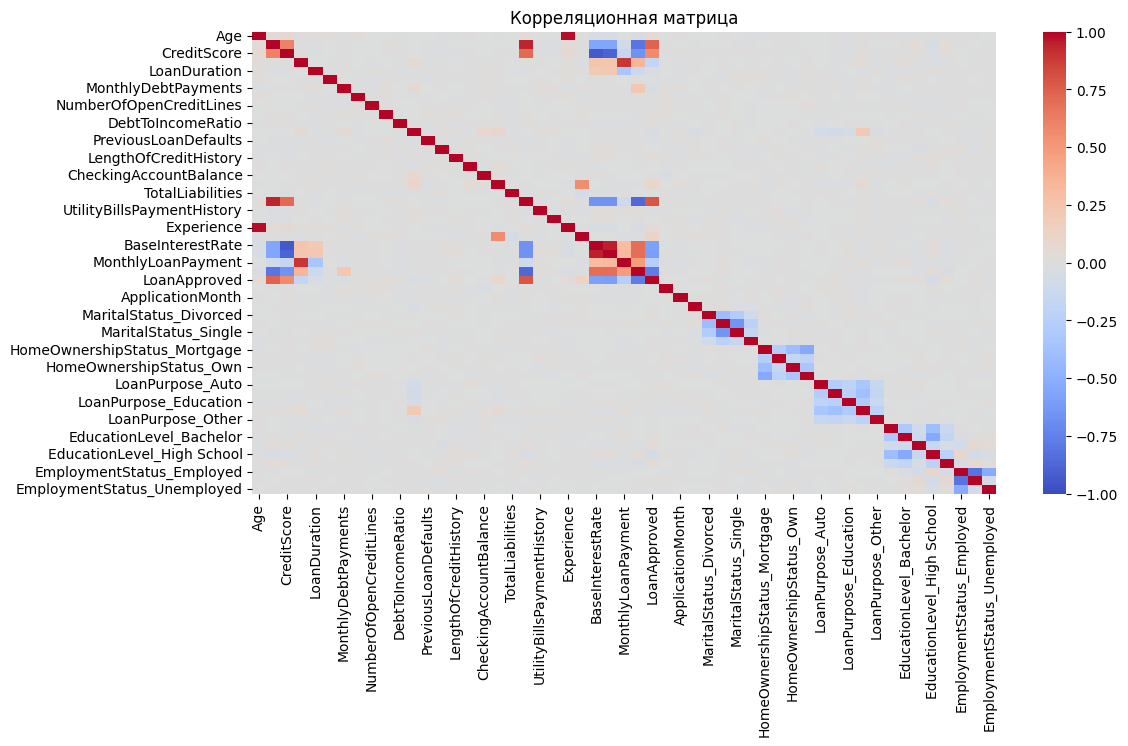

In [57]:
show_corr_matrix(dummy_train_df)

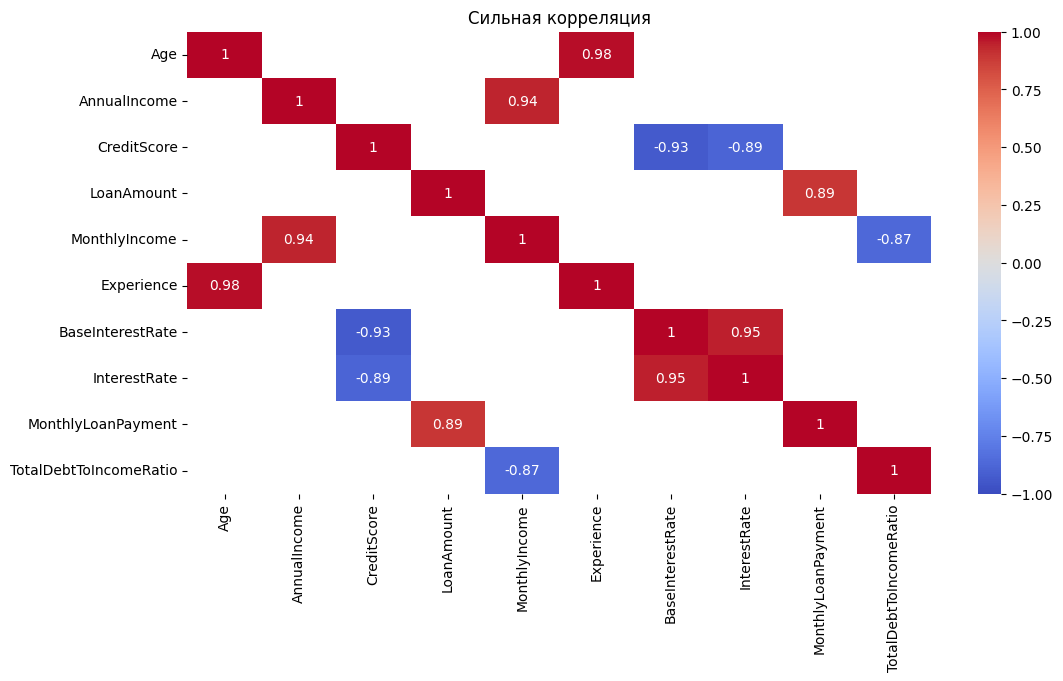

In [59]:
corr_matrix = dummy_train_df.drop(columns=[RiskScore]).corr()

weak_corr_columns = corr_matrix.columns[corr_matrix.abs().apply(lambda x: x[x < 1].max(), axis=0) < 0.85]

show_corr_matrix(
    dummy_train_df.drop(columns=weak_corr_columns),
    min_corr=0.85,
    annot=True,
    name='Сильная корреляция'
)

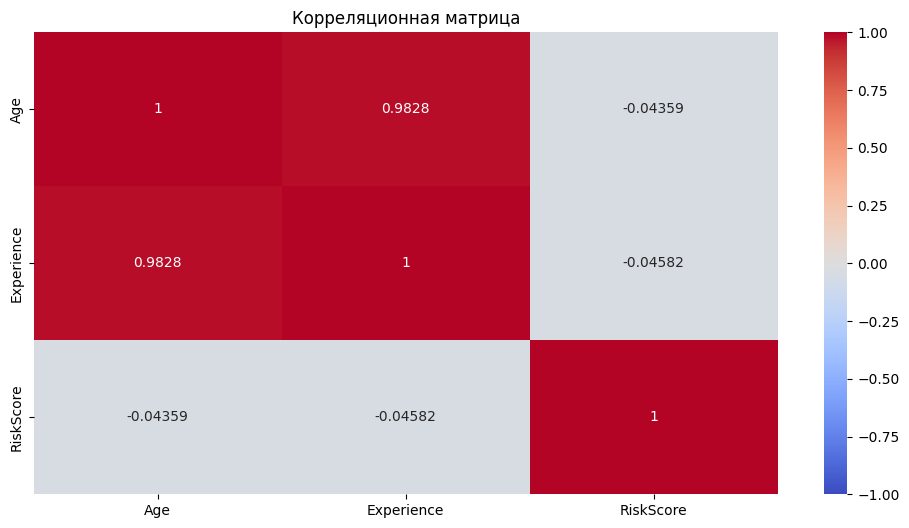

In [60]:
show_corr_matrix(dummy_train_df[[Age, Experience, RiskScore]], annot=True, dropTarget=False, fmt='.4g')

In [61]:
dummy_train_df.drop(Age, axis=1, inplace=True)
dummy_test_df.drop(Age, axis=1, inplace=True)

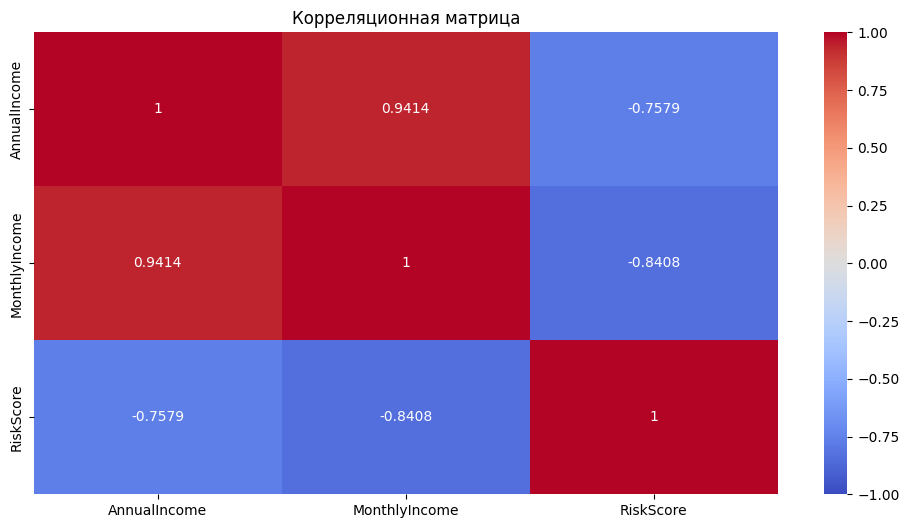

In [62]:
show_corr_matrix(dummy_train_df[[AnnualIncome, MonthlyIncome, RiskScore]], annot=True, dropTarget=False, fmt='.4g')

In [63]:
dummy_train_df.drop(AnnualIncome, axis=1, inplace=True)
dummy_test_df.drop(AnnualIncome, axis=1, inplace=True)

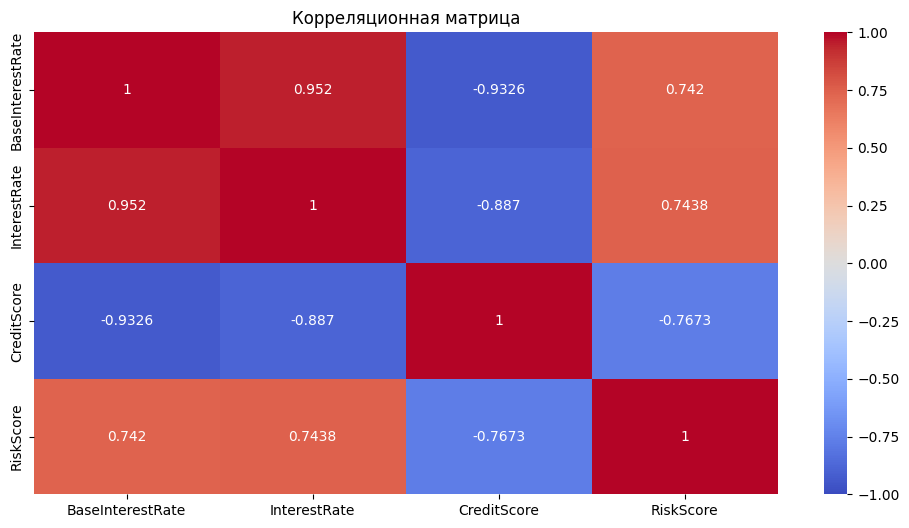

In [64]:
show_corr_matrix(dummy_train_df[[BaseInterestRate, InterestRate, CreditScore, RiskScore]], annot=True, dropTarget=False, fmt='.4g')

In [66]:
dummy_train_df.drop([BaseInterestRate], axis=1, inplace=True)
dummy_test_df.drop([BaseInterestRate], axis=1, inplace=True)

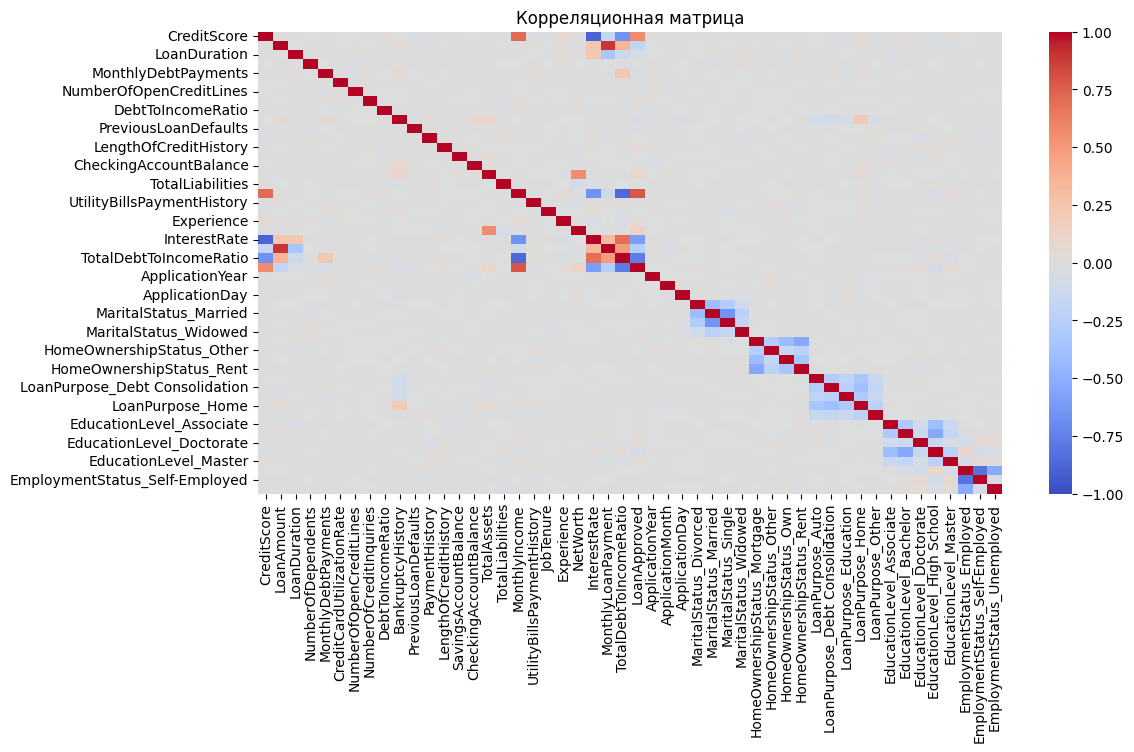

In [67]:
show_corr_matrix(dummy_train_df)

In [69]:
copy_dummy_train_df = dummy_train_df.copy()

dummy_x = copy_dummy_train_df.drop(columns=RiskScore).values
dummy_y = copy_dummy_train_df[RiskScore].values

scaler = ZScoreScaler()
dummy_x = scaler.fit_transform(dummy_x)

In [70]:
def dummy_compare_models(models, names, fold_cnt=5, metrics=[mse, mae, mape, r2]):
  scores = np.ndarray((len(names),len(metrics)))

  for i in range(len(names)):
    scores[i] = get_kfs(models[i], dummy_x, dummy_y, fold_cnt, metrics=metrics)

  return pd.DataFrame({'MSE': scores[:,0], 'MAE': scores[:,1], 'MAPE': scores[:,2], 'CV R2': scores[:,3]}, index=names)

In [ ]:
О чем я и говорил :)

In [71]:
dummy_predictor = MyLinearRegressor()
dummy_gd_predictor = MyLinearRegressor(method='gd')
dummy_sgd_predictor = MyLinearRegressor(learning_rate=10, iterations=10000, method='sgd', seed=555, alpha=1e-6)

sk_predictor = sk.linear_model.LinearRegression()
sk_sgd_predictor = sk.linear_model.SGDRegressor(penalty=None, random_state=555)

models = [dummy_predictor, dummy_gd_predictor, sgd_predictor, sk_predictor, sk_sgd_predictor]
names = ['My Dummy Analytical', 'My Dummy gd', 'My Dummy sgd', 'SK Linear Regression', 'SK SGDRegressor']

dummy_compare_models(models, names)

MSE       MAE      MAPE     CV R2
My Dummy Analytical   20.532781  3.506099  0.078967  0.930857
My Dummy gd           20.564821  3.515450  0.079131  0.930748
My Dummy sgd          57.295247  5.557512  0.122893  0.804419
SK Linear Regression  20.532781  3.506099  0.078967  0.930857
SK SGDRegressor       20.610041  3.513317  0.079160  0.930597

# Я устал, Босс

In [261]:
predictor = MyLinearRegressor()

x = train_df.drop(columns='RiskScore').values
y = train_df['RiskScore'].values
t = test_df.drop(columns='ID').values

scaler = ZScoreScaler()
x = scaler.fit_transform(x)
t = scaler.transform(t)

predictor.fit(x, y)
pred = predictor.predict(t)

df = pd.DataFrame({'ID': np.arange(0, len(pred)), RiskScore: pred.reshape(-1)})
df.to_csv('result.csv', index=False)